In [ ]:
"""
DECISION TREE - Circuit-Disjoint Split (Complete Standalone)

Compares Decision Tree against the LINEAR BASELINE:
   Tyre + Weather + State (Ridge/Linear)
  
Uses GroupKFold CV with race-balanced weights.
NO TEST LEAKAGE - test set touched only once after tuning.

This ensures a fair comparison:
  - Same target: LapTime_next_vs_stint_baseline
  - Same circuit-disjoint split
  - Same feature block (Tyre+Weather+State)
  - Different model class only (DT vs Linear)
"""
import os
import json
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GroupKFold, ParameterGrid
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor


np.random.seed(42)

In [2]:

# CONFIGURATION

OUTDIR = "csv_output/nonlinear"
os.makedirs(OUTDIR, exist_ok=True)

TRAIN_PATH = "csv_output/Train_set.xlsx"
VAL_PATH = "csv_output/Validation_set.xlsx"
TEST_PATH = "csv_output/Test_set.xlsx"

TARGET = "LapTime_next_vs_stint_baseline"
N_CV_SPLITS = 5

NUM_TYRE = ["is_new_tyre", "TyreLife", "TyreAgeAtStart"]
NUM_WEATHER = ["AirTemp", "Humidity", "Pressure", "TrackTemp", "wind_sin", "wind_cos"]
NUM_STATE = [
    "is_leader", "in_drs_range", "in_clean_air", "in_dirty_air",
    "pushing", "laptime_rolling_std_3", "delta_laptime",
    "cumulative_degradation", "LapTime"
]
GEOM_COLS_ALL = [
    'num_drs_zones', 'length_m', 'num_turns',
    'slow_share', 'slow_cluster_max',
    'straight_ratio', 'straight_len_max_m', 'n_major_straights',
    'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'hb_at_end_of_max',
    'avg_corner_angle', 'avg_corner_distance', 'drs_total_len_m'
]
CAT_FEATURES = ["Compound", "RacingNumber", "Team"]

In [3]:

# Helpers 

def keep_existing(cols, df):
    return [c for c in cols if c in df.columns]

def make_preprocessor(num_feats, cat_feats):
    transformers = [("num", SimpleImputer(strategy="median"), num_feats)]
    if len(cat_feats) > 0:
        try:
            ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        except TypeError:
            ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
        transformers.append(("cat", ohe, cat_feats))
    return ColumnTransformer(transformers, remainder="drop")

def compute_race_balanced_weights(race_series):
    vc = race_series.value_counts()
    return race_series.map(lambda r: 1.0 / vc.loc[r])

def tune_with_groupkfold_cv(pipeline, param_grid, X_trainval, y_trainval, race_trainval, n_splits=5):
    best_score = np.inf
    best_params = None
    gkf = GroupKFold(n_splits=min(n_splits, race_trainval.nunique()))
    n_configs = len(list(ParameterGrid(param_grid)))
    
    for i, params in enumerate(ParameterGrid(param_grid), 1):
        fold_scores = []
        for tr_idx, va_idx in gkf.split(X_trainval, y_trainval, groups=race_trainval):
            race_tr = race_trainval.iloc[tr_idx]
            w_tr = compute_race_balanced_weights(race_tr)
            pipeline.set_params(**params)
            pipeline.fit(X_trainval.iloc[tr_idx], y_trainval.iloc[tr_idx], model__sample_weight=w_tr.values)
            yp = pipeline.predict(X_trainval.iloc[va_idx])
            race_va = race_trainval.iloc[va_idx]
            per_race = []
            for rid in race_va.unique():
                mask_race = (race_va == rid).values
                if mask_race.sum() > 0:
                    per_race.append(mean_absolute_error(y_trainval.iloc[va_idx].values[mask_race], yp[mask_race]))
            fold_scores.append(float(np.median(per_race)))
        
        score = float(np.median(fold_scores))
        if score < best_score:
            best_score = score
            best_params = params
        if i % 50 == 0 or i == n_configs:
            print(f"  [{i}/{n_configs}] Best: {best_score:.4f}s")
    
    return best_params, best_score

def refit_and_test_once(pipeline, best_params, X_trainval, y_trainval, race_trainval,
                        df_test_sorted, num_feats, cat_feats, target):
    w_trainval = compute_race_balanced_weights(race_trainval)
    pipeline.set_params(**best_params)
    pipeline.fit(X_trainval, y_trainval, model__sample_weight=w_trainval.values)
    
    X_test = df_test_sorted[num_feats + cat_feats].copy()
    y_test = df_test_sorted[target].astype(float).copy()
    test_pred_all = pipeline.predict(X_test)
    
    mask = y_test.notna()
    test_pred = test_pred_all[mask]
    y_test_valid = y_test[mask]
    
    # Overall metrics
    test_mae = float(mean_absolute_error(y_test_valid, test_pred))
    test_rmse = float(np.sqrt(mean_squared_error(y_test_valid, test_pred)))
    test_r2 = float(r2_score(y_test_valid, test_pred))
    
    # Per-circuit metrics (for generalization stability)
    per_circuit_mae = []
    circuit_ids = []
    n_test_per_circuit = []
    for circuit_name in df_test_sorted['name'].unique():
        circuit_mask = (df_test_sorted['name'] == circuit_name).values
        circuit_mask = circuit_mask & mask.values
        if circuit_mask.sum() > 0:
            circuit_mae = mean_absolute_error(
                df_test_sorted[target].values[circuit_mask], 
                test_pred_all[circuit_mask]
            )
            per_circuit_mae.append(circuit_mae)
            circuit_ids.append(str(circuit_name))
            n_test_per_circuit.append(int(circuit_mask.sum()))
    
    # Generalization stability metrics
    median_mae_per_circuit = float(np.median(per_circuit_mae))
    q75 = float(np.percentile(per_circuit_mae, 75))
    q25 = float(np.percentile(per_circuit_mae, 25))
    iqr_mae_per_circuit = q75 - q25
    
    # Also compute per-race for detailed analysis (optional)
    per_race_mae = []
    race_ids = []
    for (year, round_no, circuit), g in df_test_sorted.groupby(['year', 'round', 'name'], sort=False):
        group_indices = g.index.values
        group_mask = np.zeros(len(df_test_sorted), dtype=bool)
        group_mask[group_indices] = True
        group_mask = group_mask & mask.values
        if group_mask.sum() > 0:
            race_mae = mean_absolute_error(df_test_sorted[target].values[group_mask], test_pred_all[group_mask])
            per_race_mae.append(race_mae)
            race_ids.append(f"{year}_{round_no}_{circuit}")
    
    return pipeline, {
        "MAE": test_mae,
        "RMSE": test_rmse,
        "R2": test_r2,
        "median_MAE_per_circuit": median_mae_per_circuit,
        "IQR_MAE_per_circuit": iqr_mae_per_circuit,
        "Q25_MAE_per_circuit": q25,
        "Q75_MAE_per_circuit": q75,
        "per_circuit_mae": per_circuit_mae,
        "circuit_ids": circuit_ids,
        "n_test_per_circuit": n_test_per_circuit,
        "per_race_mae": per_race_mae,
        "race_ids": race_ids,
    }



In [4]:


print("="*100)
print("DECISION TREE - Baseline vs Baseline+Geometry")
print("="*100)

# Load data
print("\nLoading data...")
df_train = pd.read_excel(TRAIN_PATH)
df_val = pd.read_excel(VAL_PATH)
df_test = pd.read_excel(TEST_PATH)
print(f"Train: {len(df_train):,} | Val: {len(df_val):,} | Test: {len(df_test):,}")

assert TARGET in df_train.columns, f"Target '{TARGET}' not found!"

# SANITY CHECK: Verify circuit-disjoint splits (no circuit overlap)
train_c = set(df_train["name"].unique())
val_c   = set(df_val["name"].unique())
test_c  = set(df_test["name"].unique())
assert train_c.isdisjoint(val_c) and train_c.isdisjoint(test_c) and val_c.isdisjoint(test_c), "ERROR: Circuit overlap in splits!"
print("✓ Verified: no circuit overlap across Train/Val/Test")

# Ensure is_new_tyre
for df in [df_train, df_val, df_test]:
    if 'is_new_tyre' not in df.columns and 'TyreAgeAtStart' in df.columns:
        df['is_new_tyre'] = (df['TyreAgeAtStart'] == 0).astype(int)

# Create race_id (for per-race reporting) and circuit_id (for unseen-circuit CV grouping)
for df in [df_train, df_val, df_test]:
    df['race_id'] = (
        df['year'].astype(str) + '_' + 
        df['round'].astype(str) + '_' + 
        df['name'].astype(str)
    )
    df['circuit_id'] = df['name'].astype(str)  # For unseen-circuit CV grouping

# Prepare features
num_tyre = keep_existing(NUM_TYRE, df_train)
num_weather = keep_existing(NUM_WEATHER, df_train)
num_state = keep_existing(NUM_STATE, df_train)
num_geometry = [c for c in GEOM_COLS_ALL if c in df_train.columns and c != "hb_at_end_of_max"]
CAT = keep_existing(CAT_FEATURES, df_train)

feat_baseline = num_tyre + num_weather + num_state
feat_with_geom = num_tyre + num_weather + num_state + num_geometry

print(f"\nFeature sets:")
print(f"  Baseline (Tyre+Weather+State): {len(feat_baseline)} features")
print(f"  +Geometry: {len(feat_with_geom)} features (+{len(feat_with_geom)-len(feat_baseline)})")

# Combine train+val
df_trainval = pd.concat([df_train, df_val], axis=0, ignore_index=True)
print(f"\nTrain+Val: {len(df_trainval):,} samples, {df_trainval['circuit_id'].nunique()} unique circuits")

# Sort test
sort_cols = ['year', 'round', 'name']
if 'lap_number' in df_test.columns:
    sort_cols.append('lap_number')
elif 'LapNumber' in df_test.columns:
    sort_cols.append('LapNumber')
df_test_sorted = df_test.sort_values(sort_cols).reset_index(drop=True)

# Hyperparameter grid
# param_dt = {
#     "model__max_depth": [6, 10],
#     "model__min_samples_leaf": [5, 10],
#     "model__max_features": ["sqrt", 0.5],
#     "model__ccp_alpha": [0.0, 1e-4],
# }

# For more extensive search (commented out as in original):
param_dt = {
    "model__max_depth": [4, 6, 8, 12],
    "model__min_samples_leaf": [5, 10, 20],
    "model__min_samples_split": [2, 10],
    "model__max_features": [None, "sqrt", 0.5],
    "model__max_leaf_nodes": [None, 64, 128, 256],
    "model__ccp_alpha": [0.0, 1e-4, 5e-4],
}


n_configs = len(list(ParameterGrid(param_dt)))
print(f"Hyperparameter grid: {n_configs} configs\n")

# =========================================================
# RUN BOTH FEATURE SETS
# =========================================================
results = []

for set_name, num_feats in [("Tyre+Weather+State", feat_baseline), 
                             ("Tyre+Weather+State+Geometry", feat_with_geom)]:
    print("="*100)
    print(f"{set_name}")
    print("="*100)
    
    X_trainval = df_trainval[num_feats + CAT].copy()
    y_trainval = df_trainval[TARGET].astype(float).copy()
    circuit_trainval = df_trainval['circuit_id'].copy()  # Unseen-circuit grouping
    race_trainval = df_trainval['race_id'].copy()        # For per-race reporting
    
    mask_trainval = y_trainval.notna()
    X_trainval = X_trainval.loc[mask_trainval]
    y_trainval = y_trainval.loc[mask_trainval]
    circuit_trainval = circuit_trainval.loc[mask_trainval]
    race_trainval = race_trainval.loc[mask_trainval]
    
    print(f"Samples: {len(X_trainval):,}")
    print(f"Unique circuits (CV groups): {circuit_trainval.nunique()}")
    
    preprocessor = make_preprocessor(num_feats, CAT)
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("model", DecisionTreeRegressor(random_state=42))
    ])
    
    print(f"Tuning ({len(X_trainval):,} train samples)...")
    best_params, best_cv_score = tune_with_groupkfold_cv(
        pipeline=pipeline,
        param_grid=param_dt,
        X_trainval=X_trainval,
        y_trainval=y_trainval,
        race_trainval=circuit_trainval,  # Group by CIRCUIT for unseen-circuit CV
        n_splits=N_CV_SPLITS
    )
    
    pipeline_fitted, test_results = refit_and_test_once(
        pipeline=pipeline,
        best_params=best_params,
        X_trainval=X_trainval,
        y_trainval=y_trainval,
        race_trainval=circuit_trainval,  # Weight by CIRCUIT
        df_test_sorted=df_test_sorted,
        num_feats=num_feats,
        cat_feats=CAT,
        target=TARGET
    )
    
    tree_depth = pipeline_fitted.named_steps['model'].get_depth()
    tree_leaves = pipeline_fitted.named_steps['model'].get_n_leaves()
    
    print(f"\nResults:")
    print(f"  Test MAE:                    {test_results['MAE']:.4f}s")
    print(f"  Test RMSE:                   {test_results['RMSE']:.4f}s")
    print(f"  Median MAE per circuit:      {test_results['median_MAE_per_circuit']:.4f}s")
    print(f"  IQR MAE per circuit:         {test_results['IQR_MAE_per_circuit']:.4f}s")
    print(f"  CV MAE:                      {best_cv_score:.4f}s")
    print(f"  Tree depth:                  {tree_depth}")
    print(f"  Tree leaves:                 {tree_leaves}")
    
    results.append({
        "block": set_name,
        "n_features": len(num_feats) + len(CAT),
        "test_MAE": test_results['MAE'],
        "test_RMSE": test_results['RMSE'],
        "test_R2": test_results['R2'],
        "median_MAE_per_circuit": test_results['median_MAE_per_circuit'],
        "IQR_MAE_per_circuit": test_results['IQR_MAE_per_circuit'],
        "tree_depth": tree_depth,
        "tree_leaves": tree_leaves,
        "CV_MAE": best_cv_score,
        "best_params": json.dumps(best_params),
    })
    
    # Save per-circuit MAE
    per_circuit_df = pd.DataFrame({
        'Circuit': test_results['circuit_ids'],
        'n_test': test_results['n_test_per_circuit'],
        'MAE': test_results['per_circuit_mae']
    }).sort_values('MAE', ascending=False)
    per_circuit_path = os.path.join(OUTDIR, f"dt_{set_name.replace('+', '_')}_per_circuit_mae.csv")
    per_circuit_df.to_csv(per_circuit_path, index=False)
    
    # Save model config as JSON
    model_info = {
        "model": "DecisionTree",
        "feature_set": set_name,
        "n_features": len(num_feats) + len(CAT),
        "best_params": best_params,
        "test_MAE": float(test_results['MAE']),
        "test_RMSE": float(test_results['RMSE']),
        "test_R2": float(test_results['R2']),
        "median_MAE_per_circuit": float(test_results['median_MAE_per_circuit']),
        "IQR_MAE_per_circuit": float(test_results['IQR_MAE_per_circuit']),
        "CV_MAE": float(best_cv_score),
        "tree_depth": int(tree_depth),
        "tree_leaves": int(tree_leaves),
    }
    model_json_path = os.path.join(OUTDIR, f"dt_{set_name.replace('+', '_')}_config.json")
    with open(model_json_path, 'w') as f:
        json.dump(model_info, f, indent=2)


DECISION TREE - Baseline vs Baseline+Geometry

Loading data...
Train: 26,221 | Val: 7,199 | Test: 6,976
✓ Verified: no circuit overlap across Train/Val/Test

Feature sets:
  Baseline (Tyre+Weather+State): 18 features
  +Geometry: 29 features (+11)

Train+Val: 33,420 samples, 19 unique circuits
Hyperparameter grid: 864 configs

Tyre+Weather+State
Samples: 33,420
Unique circuits (CV groups): 19
Tuning (33,420 train samples)...
  [50/864] Best: 0.3808s
  [100/864] Best: 0.3808s
  [150/864] Best: 0.3730s
  [200/864] Best: 0.3730s
  [250/864] Best: 0.3730s
  [300/864] Best: 0.3730s
  [350/864] Best: 0.3730s
  [400/864] Best: 0.3730s
  [450/864] Best: 0.3730s
  [500/864] Best: 0.3730s
  [550/864] Best: 0.3730s
  [600/864] Best: 0.3730s
  [650/864] Best: 0.3730s
  [700/864] Best: 0.3730s
  [750/864] Best: 0.3723s
  [800/864] Best: 0.3723s
  [850/864] Best: 0.3723s
  [864/864] Best: 0.3723s

Results:
  Test MAE:                    0.3451s
  Test RMSE:                   0.5165s
  Median MAE per

In [10]:
# DECISION TREE SUMMARY - CLEAN REPORT-READY TABLE

print("\n" + "="*100)
print("DECISION TREE - RESULTS")
print("="*100)

summary = pd.DataFrame(results)

# Add ΔMAE vs previous block
summary['ΔMAE_vs_prev'] = summary['test_MAE'].diff()

# Reorder columns for clean display
report_cols = [
    'block', 
    'n_features', 
    'test_MAE', 
    'test_RMSE',
    'test_R2',
    'median_MAE_per_circuit', 
    'IQR_MAE_per_circuit',
    'ΔMAE_vs_prev'
]

# Save full summary
summary_path = os.path.join(OUTDIR, "dt_comparison.csv")
summary.to_csv(summary_path, index=False)

# Display clean report table
print("\n" + summary[report_cols].to_string(index=False))

# Brief interpretation
if len(summary) > 1:
    baseline = summary.iloc[0]
    with_geom = summary.iloc[1]
    diff_mae = with_geom['test_MAE'] - baseline['test_MAE']
    
    print("\n" + "="*100)
    print("INTERPRETATION")
    print("="*100)
    print(f"\nBaseline (no geometry): {baseline['test_MAE']:.4f}s")
    print(f"With geometry:          {with_geom['test_MAE']:.4f}s")
    print(f"ΔMAE:                   {diff_mae:+.4f}s")

    if abs(diff_mae) < 0.0001:
        print("→ Geometry: NEUTRAL")
    elif diff_mae < 0:
        print(f"→ Geometry: HELPS")
    else:
        print(f"→ Geometry: HURTS")

print(f"\n✓ Results saved to {OUTDIR}/dt_comparison.csv")


DECISION TREE - RESULTS

                      block  n_features  test_MAE  test_RMSE   test_R2  median_MAE_per_circuit  IQR_MAE_per_circuit  ΔMAE_vs_prev
         Tyre+Weather+State          21  0.345124   0.516537  0.251697                0.338941             0.054982           NaN
Tyre+Weather+State+Geometry          32  0.483366   0.791382 -0.756493                0.362728             0.130510      0.138242

INTERPRETATION

Baseline (no geometry): 0.3451s
With geometry:          0.4834s
ΔMAE:                   +0.1382s
→ Geometry: HURTS

✓ Results saved to csv_output/nonlinear/dt_comparison.csv


In [6]:
#====================================================
# RANDOM FOREST - NESTED FEATURE LADDER
# =========================================================
print("\n" + "="*100)
print("RANDOM FOREST - Nested Feature Blocks (Tyre → +Weather → +State → +Geometry)")
print("="*100)

# Define nested feature sets (matching linear.py structure)
feat_tyre = num_tyre
feat_tyre_weather = num_tyre + num_weather
feat_tyre_weather_state = num_tyre + num_weather + num_state
feat_tyre_weather_state_geom = num_tyre + num_weather + num_state + num_geometry

print(f"\nFeature ladder:")
print(f"  1) Tyre:                        {len(feat_tyre)} features")
print(f"  2) Tyre+Weather:                {len(feat_tyre_weather)} features")
print(f"  3) Tyre+Weather+State:          {len(feat_tyre_weather_state)} features")
print(f"  4) Tyre+Weather+State+Geometry: {len(feat_tyre_weather_state_geom)} features")

# Random Forest hyperparameter grid
# param_rf = {
#     "model__n_estimators": [300, 600],
#     "model__max_depth": [8, 12, None],
#     "model__min_samples_leaf": [1, 5, 20],
#     "model__max_features": ["sqrt", 0.5],
# }

#More extensive grid (commented):
param_rf = {
    "model__n_estimators": [100, 300, 600],
    "model__max_depth": [8, 12, 16, None],
    "model__min_samples_leaf": [1, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__max_features": ["sqrt", 0.5, 0.7],
}

n_configs_rf = len(list(ParameterGrid(param_rf)))
print(f"\nHyperparameter grid - Random Forest: {n_configs_rf} configs\n")

rf_results = []

# NESTED FEATURE LADDER
feature_sets = [
    ("1) Tyre", feat_tyre),
    ("2) Tyre+Weather", feat_tyre_weather),
    ("3) Tyre+Weather+State", feat_tyre_weather_state),
    ("4) Tyre+Weather+State+Geometry", feat_tyre_weather_state_geom),
]

for set_name, num_feats in feature_sets:
    print("\n" + "="*100)
    print(f"{set_name}")
    print("="*100)
    
    X_trainval = df_trainval[num_feats + CAT].copy()
    y_trainval = df_trainval[TARGET].astype(float).copy()
    circuit_trainval = df_trainval['circuit_id'].copy()  # Unseen-circuit grouping
    
    mask_trainval = y_trainval.notna()
    X_trainval = X_trainval.loc[mask_trainval]
    y_trainval = y_trainval.loc[mask_trainval]
    circuit_trainval = circuit_trainval.loc[mask_trainval]
    
    preprocessor = make_preprocessor(num_feats, CAT)
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
    ])
    
    print(f"Tuning ({len(X_trainval):,} train samples, {len(num_feats)} numeric + {len(CAT)} categorical features)...")
    best_params, best_cv_score = tune_with_groupkfold_cv(
        pipeline=pipeline,
        param_grid=param_rf,
        X_trainval=X_trainval,
        y_trainval=y_trainval,
        race_trainval=circuit_trainval,  # Group by CIRCUIT for unseen-circuit CV
        n_splits=N_CV_SPLITS
    )
    
    pipeline_fitted, test_results = refit_and_test_once(
        pipeline=pipeline,
        best_params=best_params,
        X_trainval=X_trainval,
        y_trainval=y_trainval,
        race_trainval=circuit_trainval,  # Weight by CIRCUIT
        df_test_sorted=df_test_sorted,
        num_feats=num_feats,
        cat_feats=CAT,
        target=TARGET
    )
    
    n_estimators = pipeline_fitted.named_steps['model'].n_estimators
    
    print(f"\nResults:")
    print(f"  Test MAE:                    {test_results['MAE']:.4f}s")
    print(f"  Test RMSE:                   {test_results['RMSE']:.4f}s")
    print(f"  Median MAE per circuit:      {test_results['median_MAE_per_circuit']:.4f}s")
    print(f"  IQR MAE per circuit:         {test_results['IQR_MAE_per_circuit']:.4f}s")
    print(f"  CV MAE:                      {best_cv_score:.4f}s")
    print(f"  N estimators:                {n_estimators}")
    
    rf_results.append({
        "block": set_name,
        "n_features": len(num_feats) + len(CAT),
        "test_MAE": test_results['MAE'],
        "test_RMSE": test_results['RMSE'],
        "test_R2": test_results['R2'],
        "median_MAE_per_circuit": test_results['median_MAE_per_circuit'],
        "IQR_MAE_per_circuit": test_results['IQR_MAE_per_circuit'],
        "n_estimators": n_estimators,
        "CV_MAE": best_cv_score,
        "best_params": json.dumps(best_params),
    })
    
    # Save per-circuit MAE
    per_circuit_df = pd.DataFrame({
        'Circuit': test_results['circuit_ids'],
        'n_test': test_results['n_test_per_circuit'],
        'MAE': test_results['per_circuit_mae']
    }).sort_values('MAE', ascending=False)
    per_circuit_path = os.path.join(OUTDIR, f"rf_{set_name.replace('+', '_').replace(')', '').replace('(', '').strip()}_per_circuit_mae.csv")
    per_circuit_df.to_csv(per_circuit_path, index=False)
    
    # Save per-race MAE (for detailed analysis)
    per_race_df = pd.DataFrame({
        'Race': test_results['race_ids'],
        'MAE': test_results['per_race_mae']
    }).sort_values('MAE', ascending=False)
    per_race_path = os.path.join(OUTDIR, f"rf_{set_name.replace('+', '_').replace(')', '').replace('(', '').strip()}_per_race_mae.csv")
    per_race_df.to_csv(per_race_path, index=False)
    
    # Save model config as JSON (for reproducibility)
    model_info = {
        "model": "RandomForest",
        "feature_set": set_name,
        "n_features": len(num_feats) + len(CAT),
        "best_params": best_params,
        "test_MAE": float(test_results['MAE']),
        "test_RMSE": float(test_results['RMSE']),
        "median_MAE_per_circuit": float(test_results['median_MAE_per_circuit']),
        "IQR_MAE_per_circuit": float(test_results['IQR_MAE_per_circuit']),
        "CV_MAE": float(best_cv_score),
        "n_estimators": int(n_estimators),
    }
    model_json_path = os.path.join(OUTDIR, f"rf_{set_name.replace('+', '_').replace(')', '').replace('(', '').strip()}_config.json")
    with open(model_json_path, 'w') as f:
        json.dump(model_info, f, indent=2)




RANDOM FOREST - Nested Feature Blocks (Tyre → +Weather → +State → +Geometry)

Feature ladder:
  1) Tyre:                        3 features
  2) Tyre+Weather:                9 features
  3) Tyre+Weather+State:          18 features
  4) Tyre+Weather+State+Geometry: 29 features

Hyperparameter grid - Random Forest: 432 configs


1) Tyre
Tuning (33,420 train samples, 3 numeric + 3 categorical features)...
  [50/432] Best: 0.4459s
  [100/432] Best: 0.4459s
  [150/432] Best: 0.4459s
  [200/432] Best: 0.4459s
  [250/432] Best: 0.4459s
  [300/432] Best: 0.4459s
  [350/432] Best: 0.4459s
  [400/432] Best: 0.4459s
  [432/432] Best: 0.4459s

Results:
  Test MAE:                    0.4660s
  Test RMSE:                   0.6535s
  Median MAE per circuit:      0.4764s
  IQR MAE per circuit:         0.0792s
  CV MAE:                      0.4459s
  N estimators:                100

2) Tyre+Weather
Tuning (33,420 train samples, 9 numeric + 3 categorical features)...
  [50/432] Best: 0.4580s
  [100/432

In [9]:

# RANDOM FOREST SUMMARY - CLEAN REPORT-READY TABLE

print("\n" + "="*100)
print("RANDOM FOREST - NESTED FEATURE LADDER RESULTS")
print("="*100)

rf_summary = pd.DataFrame(rf_results)

# Add ΔMAE vs previous block (absolute only)
rf_summary['ΔMAE_vs_prev'] = rf_summary['test_MAE'].diff()

# Reorder columns for clean display
report_cols = [
    'block', 
    'n_features', 
    'test_MAE', 
    'test_RMSE',
    'test_R2',
    'median_MAE_per_circuit', 
    'IQR_MAE_per_circuit',
    'ΔMAE_vs_prev',

]

# Save full summary
rf_summary_path = os.path.join(OUTDIR, "rf_nested_comparison.csv")
rf_summary.to_csv(rf_summary_path, index=False)

# Display clean report table
print("\n" + rf_summary[report_cols].to_string(index=False))

# Brief interpretation
print("\n" + "="*100)
print("INTERPRETATION")
print("="*100)
best_block = rf_summary.loc[rf_summary['test_MAE'].idxmin(), 'block']
print(f"\nBest performing block: {best_block}")
print(f"  MAE: {rf_summary['test_MAE'].min():.4f}s")
print(f"  IQR: {rf_summary.loc[rf_summary['test_MAE'].idxmin(), 'IQR_MAE_per_circuit']:.4f}s")

# Show which block added most value
if len(rf_summary) > 1:
    rf_summary['abs_improvement'] = -rf_summary['ΔMAE_vs_prev']
    best_improvement_idx = rf_summary['abs_improvement'].idxmax()
    if pd.notna(rf_summary.loc[best_improvement_idx, 'abs_improvement']):
        best_improvement_block = rf_summary.loc[best_improvement_idx, 'block']
        best_improvement_value = rf_summary.loc[best_improvement_idx, 'abs_improvement']
        print(f"\nLargest improvement from: {best_improvement_block}")
        print(f"  ΔMAE: {-best_improvement_value:.4f}s")

print(f"\n✓ Results saved to {OUTDIR}/rf_nested_comparison.csv")
print(f"✓ Per-circuit MAE files saved for detailed analysis")




RANDOM FOREST - NESTED FEATURE LADDER RESULTS

                         block  n_features  test_MAE  test_RMSE   test_R2  median_MAE_per_circuit  IQR_MAE_per_circuit  ΔMAE_vs_prev
                       1) Tyre           6  0.465969   0.653492 -0.197720                0.476446             0.079171           NaN
               2) Tyre+Weather          12  0.465746   0.661255 -0.226345                0.489367             0.035337     -0.000223
         3) Tyre+Weather+State          21  0.334849   0.485914  0.337795                0.340439             0.037575     -0.130897
4) Tyre+Weather+State+Geometry          32  0.333403   0.484214  0.342419                0.336098             0.043820     -0.001446

INTERPRETATION

Best performing block: 4) Tyre+Weather+State+Geometry
  MAE: 0.3334s
  IQR: 0.0438s

Largest improvement from: 3) Tyre+Weather+State
  ΔMAE: -0.1309s

✓ Results saved to csv_output/nonlinear/rf_nested_comparison.csv
✓ Per-circuit MAE files saved for detailed analysis


In [80]:
# Rf residuals 

# Use RF with Geometry as the best model (for comparison with Linear)
best_rf_block = '4) Tyre+Weather+State+Geometry'
best_rf_idx = rf_summary[rf_summary['block'] == best_rf_block].index[0]
best_rf_mae = rf_summary.loc[best_rf_idx, 'test_MAE']

print(f"\nBest RF model (for comparison): {best_rf_block}")
print(f"  Test MAE: {best_rf_mae:.4f}s")

# Recreate the best RF model with best parameters
best_rf_params = json.loads(rf_summary.loc[best_rf_idx, 'best_params'])

# Use full feature set (Tyre+Weather+State+Geometry)
best_num_feats = num_tyre + num_weather + num_state + num_geometry

print(f"  Features: {len(best_num_feats)} numeric + {len(CAT)} categorical")

# Prepare training data
X_trainval = df_trainval[best_num_feats + CAT].copy()
y_trainval = df_trainval[TARGET].astype(float).copy()
circuit_trainval = df_trainval['circuit_id'].copy()

mask_trainval = y_trainval.notna()
X_trainval = X_trainval.loc[mask_trainval]
y_trainval = y_trainval.loc[mask_trainval]
circuit_trainval = circuit_trainval.loc[mask_trainval]

# Build and fit pipeline
preprocessor = make_preprocessor(best_num_feats, CAT)
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

pipeline.set_params(**best_rf_params)
w_trainval = compute_race_balanced_weights(circuit_trainval)
pipeline.fit(X_trainval, y_trainval, model__sample_weight=w_trainval.values)

print(" RF model refitted")

# Predict on test set
X_test = df_test_sorted[best_num_feats + CAT].copy()
y_test = df_test_sorted[TARGET].astype(float).copy()
test_pred_all = pipeline.predict(X_test)

mask_test = y_test.notna()
test_pred = test_pred_all[mask_test]
y_test_valid = y_test[mask_test]

# Compute residuals (y_true - y_pred)
residuals = y_test_valid.values - test_pred

# Create output dataframe with residuals
df_test_valid = df_test_sorted.loc[mask_test].copy()
df_rf_residuals = df_test_valid[[
    'year', 'round', 'name', 'circuit_id', 'RacingNumber', 'Team',
    'Compound', 'TyreLife', 'TrackTemp', 'Stint', 'lap_number'
]].copy()
df_rf_residuals['y_true'] = y_test_valid.values
df_rf_residuals['y_pred'] = test_pred
df_rf_residuals['residual'] = residuals  # y_true - y_pred

# Save residuals
df_rf_residuals.to_csv("csv_output/nonlinear/rf_test_residuals.csv", index=False)
print(f"\n✓ Saved RF residuals: csv_output/nonlinear/rf_test_residuals.csv")


# Compute per-circuit bias for RF (using circuit_id for consistency with training)
print("\nRF Per-Circuit Bias (mean signed error):")
df_rf_bias = df_rf_residuals.groupby('circuit_id', as_index=False).agg({
    'residual': ['mean', 'count'],
    'name': 'first'
})
df_rf_bias.columns = ['circuit_id', 'bias_RF', 'n', 'Circuit']
df_rf_bias = df_rf_bias[['Circuit', 'n', 'bias_RF']].sort_values('Circuit')

for _, row in df_rf_bias.iterrows():
    print(f"  {row['Circuit']:25s}: bias={row['bias_RF']:+.4f}s (n={int(row['n'])})")

# Save RF bias with explicit feature set name (matches per_circuit_mae naming)
df_rf_bias.to_csv("csv_output/nonlinear/rf_4_Tyre_Weather_State_Geometry_per_circuit_bias.csv", index=False)
print(f"\n Saved RF per-circuit bias: csv_output/nonlinear/rf_4_Tyre_Weather_State_Geometry_per_circuit_bias.csv")




Best RF model (for comparison): 4) Tyre+Weather+State+Geometry
  Test MAE: 0.3334s
  Features: 29 numeric + 3 categorical
 RF model refitted

✓ Saved RF residuals: csv_output/nonlinear/rf_test_residuals.csv

RF Per-Circuit Bias (mean signed error):
  Bahrain                  : bias=+0.2009s (n=1672)
  Enzo e Dino Ferrari      : bias=+0.0496s (n=1046)
  Red Bull Ring            : bias=+0.0659s (n=1346)
  Spa-Francorchamps        : bias=+0.0994s (n=1611)
  Zandvoort                : bias=+0.0525s (n=1301)

 Saved RF per-circuit bias: csv_output/nonlinear/rf_4_Tyre_Weather_State_Geometry_per_circuit_bias.csv


In [11]:

# =========================================================
# HIST GRADIENT BOOSTING - NESTED FEATURE LADDER
# =========================================================
print("\n\n" + "="*100)
print("HIST GRADIENT BOOSTING - Nested Feature Blocks (Tyre → +Weather → +State → +Geometry)")
print("="*100)

# Helper function (HGB-specific, no sample_weight)
def tune_hgb_with_groupkfold_cv(pipeline, param_grid, X_trainval, y_trainval, circuit_trainval, 
                                 n_splits=5):
    """
    GroupKFold CV for HistGradientBoosting (NO sample_weight - not supported).
    Returns best params based on median MAE per circuit across folds.
    Groups by CIRCUIT for unseen-circuit evaluation.
    """
    best_score = np.inf
    best_params = None
    
    gkf = GroupKFold(n_splits=min(n_splits, circuit_trainval.nunique()))
    n_configs = len(list(ParameterGrid(param_grid)))
    
    print(f"  Running GroupKFold CV ({n_splits} splits, {n_configs} configs, grouped by CIRCUIT)...")
    
    for i, params in enumerate(ParameterGrid(param_grid), 1):
        fold_scores = []
        
        for tr_idx, va_idx in gkf.split(X_trainval, y_trainval, groups=circuit_trainval):
            pipeline.set_params(**params)
            pipeline.fit(X_trainval.iloc[tr_idx], y_trainval.iloc[tr_idx])
            
            yp = pipeline.predict(X_trainval.iloc[va_idx])
            
            circuit_va = circuit_trainval.iloc[va_idx]
            per_circuit = []
            for cid in circuit_va.unique():
                mask_circuit = (circuit_va == cid).values
                if mask_circuit.sum() > 0:
                    per_circuit.append(mean_absolute_error(
                        y_trainval.iloc[va_idx].values[mask_circuit], 
                        yp[mask_circuit]
                    ))
            
            fold_scores.append(float(np.median(per_circuit)))
        
        score = float(np.median(fold_scores))
        
        if score < best_score:
            best_score = score
            best_params = params
        
        if i % 50 == 0 or i == n_configs:
            print(f"    [{i}/{n_configs}] Best CV: {best_score:.4f}s")
    
    print(f"  ✓ Best CV score: {best_score:.4f}s")
    return best_params, best_score

# Hyperparameter grid
# param_hgb = {
#     "model__max_depth": [3, 5, None],
#     "model__learning_rate": [0.05, 0.1],
#     "model__max_iter": [300, 600],
#     "model__min_samples_leaf": [20, 50],
# }

# More extensive grid:
param_hgb = {
    "model__max_depth": [3, 5, 7, None],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__max_iter": [100, 300, 600, 1000],
    "model__min_samples_leaf": [20, 50, 100],
    "model__l2_regularization": [0.0, 0.1, 1.0],
}

n_configs_hgb = len(list(ParameterGrid(param_hgb)))
print(f"\nHyperparameter grid - HistGradientBoosting: {n_configs_hgb} configs\n")

hgb_results = []

# NESTED FEATURE LADDER
hgb_feature_sets = [
    ("1) Tyre", feat_tyre),
    ("2) Tyre+Weather", feat_tyre_weather),
    ("3) Tyre+Weather+State", feat_tyre_weather_state),
    ("4) Tyre+Weather+State+Geometry", feat_tyre_weather_state_geom),
]

for set_name, num_feats in hgb_feature_sets:
    print("\n" + "="*100)
    print(f"{set_name}")
    print("="*100)
    
    X_trainval = df_trainval[num_feats + CAT].copy()
    y_trainval = df_trainval[TARGET].astype(float).copy()
    circuit_trainval = df_trainval['circuit_id'].copy()
    
    mask_trainval = y_trainval.notna()
    X_trainval = X_trainval.loc[mask_trainval]
    y_trainval = y_trainval.loc[mask_trainval]
    circuit_trainval = circuit_trainval.loc[mask_trainval]
    
    preprocessor = make_preprocessor(num_feats, CAT)
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("model", HistGradientBoostingRegressor(random_state=42))
    ])
    
    print(f"Tuning ({len(X_trainval):,} train samples, {len(num_feats)} numeric + {len(CAT)} categorical features)...")
    best_params, best_cv_score = tune_hgb_with_groupkfold_cv(
        pipeline=pipeline,
        param_grid=param_hgb,
        X_trainval=X_trainval,
        y_trainval=y_trainval,
        circuit_trainval=circuit_trainval,
        n_splits=N_CV_SPLITS
    )
    
    # Refit and test
    pipeline.set_params(**best_params)
    pipeline.fit(X_trainval, y_trainval)
    
    X_test = df_test_sorted[num_feats + CAT].copy()
    y_test = df_test_sorted[TARGET].astype(float).copy()
    test_pred_all = pipeline.predict(X_test)
    
    mask = y_test.notna()
    test_pred = test_pred_all[mask]
    y_test_valid = y_test[mask]
    
    test_mae = float(mean_absolute_error(y_test_valid, test_pred))
    test_rmse = float(np.sqrt(mean_squared_error(y_test_valid, test_pred)))
    test_r2 = float(r2_score(y_test_valid, test_pred))
    
    # Per-circuit MAE and IQR
    per_circuit_mae = []
    circuit_names = []
    n_test_per_circuit = []
    for circuit in df_test_sorted['name'].unique():
        circuit_mask = (df_test_sorted['name'] == circuit).values
        circuit_mask = circuit_mask & mask.values
        if circuit_mask.sum() > 0:
            circuit_mae = mean_absolute_error(
                df_test_sorted[TARGET].values[circuit_mask], 
                test_pred_all[circuit_mask]
            )
            per_circuit_mae.append(circuit_mae)
            circuit_names.append(str(circuit))
            n_test_per_circuit.append(int(circuit_mask.sum()))
    
    median_mae_per_circuit = float(np.median(per_circuit_mae))
    q75 = float(np.percentile(per_circuit_mae, 75))
    q25 = float(np.percentile(per_circuit_mae, 25))
    iqr_mae_per_circuit = q75 - q25
    
    n_iter = pipeline.named_steps['model'].n_iter_
    
    print(f"\nResults:")
    print(f"  Test MAE:                    {test_mae:.4f}s")
    print(f"  Test RMSE:                   {test_rmse:.4f}s")
    print(f"  Median MAE per circuit:      {median_mae_per_circuit:.4f}s")
    print(f"  IQR MAE per circuit:         {iqr_mae_per_circuit:.4f}s")
    print(f"  CV MAE:                      {best_cv_score:.4f}s")
    print(f"  N iterations:                {n_iter}")
    
    hgb_results.append({
        "block": set_name,
        "n_features": len(num_feats) + len(CAT),
        "test_MAE": test_mae,
        "test_RMSE": test_rmse,
        "test_R2": test_r2,
        "median_MAE_per_circuit": median_mae_per_circuit,
        "IQR_MAE_per_circuit": iqr_mae_per_circuit,
        "n_iter": n_iter,
        "CV_MAE": best_cv_score,
        "best_params": json.dumps(best_params),
    })
    
    # Save per-circuit MAE
    per_circuit_df = pd.DataFrame({
        'Circuit': circuit_names,
        'n_test': n_test_per_circuit,
        'MAE': per_circuit_mae
    }).sort_values('MAE', ascending=False)
    per_circuit_path = os.path.join(OUTDIR, f"hgb_{set_name.replace('+', '_').replace(')', '').replace('(', '').strip()}_per_circuit_mae.csv")
    per_circuit_df.to_csv(per_circuit_path, index=False)
    
    # Save model config as JSON
    model_info = {
        "model": "HistGradientBoosting",
        "feature_set": set_name,
        "n_features": len(num_feats) + len(CAT),
        "best_params": best_params,
        "test_MAE": float(test_mae),
        "test_RMSE": float(test_rmse),
        "median_MAE_per_circuit": float(median_mae_per_circuit),
        "IQR_MAE_per_circuit": float(iqr_mae_per_circuit),
        "CV_MAE": float(best_cv_score),
        "n_iter": int(n_iter),
    }
    model_json_path = os.path.join(OUTDIR, f"hgb_{set_name.replace('+', '_').replace(')', '').replace('(', '').strip()}_config.json")
    with open(model_json_path, 'w') as f:
        json.dump(model_info, f, indent=2)



HIST GRADIENT BOOSTING - Nested Feature Blocks (Tyre → +Weather → +State → +Geometry)

Hyperparameter grid - HistGradientBoosting: 576 configs


1) Tyre
Tuning (33,420 train samples, 3 numeric + 3 categorical features)...
  Running GroupKFold CV (5 splits, 576 configs, grouped by CIRCUIT)...
    [50/576] Best CV: 0.4327s
    [100/576] Best CV: 0.4327s
    [150/576] Best CV: 0.4327s
    [200/576] Best CV: 0.4327s
    [250/576] Best CV: 0.4327s
    [300/576] Best CV: 0.4327s
    [350/576] Best CV: 0.4327s
    [400/576] Best CV: 0.4327s
    [450/576] Best CV: 0.4327s
    [500/576] Best CV: 0.4327s
    [550/576] Best CV: 0.4327s
    [576/576] Best CV: 0.4327s
  ✓ Best CV score: 0.4327s

Results:
  Test MAE:                    0.4462s
  Test RMSE:                   0.6358s
  Median MAE per circuit:      0.4530s
  IQR MAE per circuit:         0.0865s
  CV MAE:                      0.4327s
  N iterations:                100

2) Tyre+Weather
Tuning (33,420 train samples, 9 numeric + 3 catego

In [12]:

# HIST GRADIENT BOOSTING SUMMARY - CLEAN REPORT-READY TABLE

print("\n" + "="*100)
print("HIST GRADIENT BOOSTING - NESTED FEATURE LADDER RESULTS")
print("="*100)

hgb_summary = pd.DataFrame(hgb_results)

# Add ΔMAE vs previous block
hgb_summary['ΔMAE_vs_prev'] = hgb_summary['test_MAE'].diff()

# Reorder columns for clean display
report_cols = [
    'block', 
    'n_features', 
    'test_MAE', 
    'test_RMSE',
    'test_R2',
    'median_MAE_per_circuit', 
    'IQR_MAE_per_circuit',
    'ΔMAE_vs_prev'
]

# Save full summary
hgb_summary_path = os.path.join(OUTDIR, "hgb_nested_comparison.csv")
hgb_summary.to_csv(hgb_summary_path, index=False)

# Display clean report table
print("\n" + hgb_summary[report_cols].to_string(index=False))

# Brief interpretation
print("\n" + "="*100)
print("INTERPRETATION")
print("="*100)
best_block = hgb_summary.loc[hgb_summary['test_MAE'].idxmin(), 'block']
print(f"\nBest performing block: {best_block}")
print(f"  MAE: {hgb_summary['test_MAE'].min():.4f}s")
print(f"  IQR: {hgb_summary.loc[hgb_summary['test_MAE'].idxmin(), 'IQR_MAE_per_circuit']:.4f}s")

# Show which block added most value
if len(hgb_summary) > 1:
    hgb_summary['abs_improvement'] = -hgb_summary['ΔMAE_vs_prev']
    best_improvement_idx = hgb_summary['abs_improvement'].idxmax()
    if pd.notna(hgb_summary.loc[best_improvement_idx, 'abs_improvement']):
        best_improvement_block = hgb_summary.loc[best_improvement_idx, 'block']
        best_improvement_value = hgb_summary.loc[best_improvement_idx, 'abs_improvement']
        print(f"\nLargest improvement from: {best_improvement_block}")
        print(f"  ΔMAE: {-best_improvement_value:.4f}s")

print(f"\n✓ Results saved to {OUTDIR}/hgb_nested_comparison.csv")
print(f"✓ Per-circuit MAE files saved for detailed analysis")



HIST GRADIENT BOOSTING - NESTED FEATURE LADDER RESULTS

                         block  n_features  test_MAE  test_RMSE   test_R2  median_MAE_per_circuit  IQR_MAE_per_circuit  ΔMAE_vs_prev
                       1) Tyre           6  0.446228   0.635783 -0.133683                0.453049             0.086547           NaN
               2) Tyre+Weather          12  0.462349   0.670382 -0.260430                0.483437             0.013660      0.016121
         3) Tyre+Weather+State          21  0.334817   0.498882  0.301978                0.318171             0.036155     -0.127532
4) Tyre+Weather+State+Geometry          32  0.341894   0.506810  0.279616                0.304110             0.048441      0.007077

INTERPRETATION

Best performing block: 3) Tyre+Weather+State
  MAE: 0.3348s
  IQR: 0.0362s

Largest improvement from: 3) Tyre+Weather+State
  ΔMAE: -0.1275s

✓ Results saved to csv_output/nonlinear/hgb_nested_comparison.csv
✓ Per-circuit MAE files saved for detailed analysis


In [13]:
# =========================================================
# CATBOOST REGRESSOR
# =========================================================

print("\n\n" + "="*100)
print("CATBOOST - Circuit-Disjoint Evaluation (GroupKFold CV)")
print("="*100)

# =========================================================
# HELPER FUNCTION FOR CATBOOST (no sample_weight in sklearn pipeline)
# =========================================================
def tune_catboost_with_groupkfold_cv(param_grid, X_trainval, y_trainval, circuit_trainval, 
                                      n_splits=5, categorical_features=None):
    """
    GroupKFold CV for CatBoost (natively handles categorical features).
    Returns best params based on median MAE per circuit across folds.
    Groups by CIRCUIT for unseen-circuit evaluation.
    """
    best_score = np.inf
    best_params = None
    
    gkf = GroupKFold(n_splits=min(n_splits, circuit_trainval.nunique()))
    n_configs = len(list(ParameterGrid(param_grid)))
    
    print(f"  Running GroupKFold CV ({n_splits} splits, {n_configs} configs, grouped by CIRCUIT)...")
    
    for i, params in enumerate(ParameterGrid(param_grid), 1):
        fold_scores = []
        
        for tr_idx, va_idx in gkf.split(X_trainval, y_trainval, groups=circuit_trainval):
            # Prepare data for this fold
            X_tr = X_trainval.iloc[tr_idx].copy()
            y_tr = y_trainval.iloc[tr_idx].copy()
            X_va = X_trainval.iloc[va_idx].copy()
            y_va = y_trainval.iloc[va_idx].copy()
            
            # Train CatBoost with early stopping
            model = CatBoostRegressor(
                random_state=42,
                verbose=0,
                iterations=3000,
                early_stopping_rounds=100,
                **params
            )
            
            # Fit with validation set and categorical features
            if categorical_features:
                model.fit(
                    X_tr, y_tr,
                    cat_features=categorical_features,
                    eval_set=(X_va, y_va),
                    use_best_model=True,
                    verbose=False
                )
            else:
                model.fit(
                    X_tr, y_tr,
                    eval_set=(X_va, y_va),
                    use_best_model=True,
                    verbose=False
                )
            
            # Predict on validation fold
            yp = model.predict(X_va)
            
            # Compute per-circuit MAE for this fold
            circuit_va = circuit_trainval.iloc[va_idx]
            per_circuit = []
            for cid in circuit_va.unique():
                mask_circuit = (circuit_va == cid).values
                if mask_circuit.sum() > 0:
                    per_circuit.append(mean_absolute_error(
                        y_va.values[mask_circuit], 
                        yp[mask_circuit]
                    ))
            
            fold_scores.append(float(np.median(per_circuit)))
        
        # Median across folds
        score = float(np.median(fold_scores))
        
        if score < best_score:
            best_score = score
            best_params = params
        
        if i % 50 == 0 or i == n_configs:
            print(f"    [{i}/{n_configs}] Best CV: {best_score:.4f}s")
    
    print(f"  ✓ Best CV score: {best_score:.4f}s")
    return best_params, best_score


# =========================================================
# HYPERPARAMETER GRID FOR CATBOOST
# =========================================================
# param_catboost = {
#     "depth": [4, 6, 8],
#     "learning_rate": [0.05, 0.1],
#     "l2_leaf_reg": [1, 3, 5],
# }

# More extensive grid (commented, with early stopping iterations can be higher):
param_catboost = {
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5, 10],
    "random_strength": [0.5, 1.0],
}

n_configs_catboost = len(list(ParameterGrid(param_catboost)))
print(f"\nHyperparameter grid - CatBoost: {n_configs_catboost} configs (with early stopping)\n")

# =========================================================
# SETUP (if running CatBoost separately)
# =========================================================
# Define feature sets and data if not already in memory
try:
    feat_baseline
except NameError:
    print("Setting up features and data...")
    
    # Load data
    df_train = pd.read_excel(TRAIN_PATH)
    df_val = pd.read_excel(VAL_PATH)
    df_test = pd.read_excel(TEST_PATH)
    
    # Ensure is_new_tyre
    for df in [df_train, df_val, df_test]:
        if 'is_new_tyre' not in df.columns and 'TyreAgeAtStart' in df.columns:
            df['is_new_tyre'] = (df['TyreAgeAtStart'] == 0).astype(int)
    
    # Create circuit_id for grouping
    for df in [df_train, df_val, df_test]:
        df['race_id'] = (
            df['year'].astype(str) + '_' + 
            df['round'].astype(str) + '_' + 
            df['name'].astype(str)
        )
        df['circuit_id'] = df['name'].astype(str)
    
    # Prepare features
    num_tyre = keep_existing(NUM_TYRE, df_train)
    num_weather = keep_existing(NUM_WEATHER, df_train)
    num_state = keep_existing(NUM_STATE, df_train)
    num_geometry = [c for c in GEOM_COLS_ALL if c in df_train.columns and c != "hb_at_end_of_max"]
    CAT = keep_existing(CAT_FEATURES, df_train)
    
    feat_baseline = num_tyre + num_weather + num_state
    feat_with_geom = num_tyre + num_weather + num_state + num_geometry
    
    # Combine train+val
    df_trainval = pd.concat([df_train, df_val], axis=0, ignore_index=True)
    
    # Sort test
    sort_cols = ['year', 'round', 'name']
    if 'lap_number' in df_test.columns:
        sort_cols.append('lap_number')
    elif 'LapNumber' in df_test.columns:
        sort_cols.append('LapNumber')
    df_test_sorted = df_test.sort_values(sort_cols).reset_index(drop=True)
    
    print("✓ Features and data setup complete")



# =========================================================
# RUN CATBOOST EXPERIMENTS (using same feature sets as DT/RF/HGB)
# =========================================================
catboost_results = []

for set_name, num_feats in [("Tyre+Weather+State", feat_baseline), 
                             ("Tyre+Weather+State+Geometry", feat_with_geom)]:
    print(f"\n{set_name}")
    
    # For CatBoost, we work with raw data (not preprocessed)
    # Separate numerical and categorical
    X_trainval_raw = df_trainval[num_feats + CAT].copy()
    y_trainval_raw = df_trainval[TARGET].astype(float).copy()
    circuit_trainval_raw = df_trainval['circuit_id'].copy()
    
    mask_trainval = y_trainval_raw.notna()
    X_trainval_raw = X_trainval_raw.loc[mask_trainval]
    y_trainval_raw = y_trainval_raw.loc[mask_trainval]
    circuit_trainval_raw = circuit_trainval_raw.loc[mask_trainval]
    
    # Ensure categorical columns are strings (CatBoost requirement)
    for c in CAT:
        if c in X_trainval_raw.columns:
            X_trainval_raw[c] = X_trainval_raw[c].astype(str)
    
    # Get categorical feature indices
    cat_indices = [X_trainval_raw.columns.get_loc(c) for c in CAT if c in X_trainval_raw.columns]
    
    print(f"Tuning ({len(X_trainval_raw):,} train samples, {len(cat_indices)} categorical features)...")
    best_params, best_cv_score = tune_catboost_with_groupkfold_cv(
        param_grid=param_catboost,
        X_trainval=X_trainval_raw,
        y_trainval=y_trainval_raw,
        circuit_trainval=circuit_trainval_raw,
        n_splits=N_CV_SPLITS,
        categorical_features=cat_indices if cat_indices else None
    )
    
    # Refit and test
    final_model = CatBoostRegressor(
        random_state=42,
        verbose=0,
        iterations=3000,
        early_stopping_rounds=100,
        **best_params
    )
    
    # Prepare validation data for early stopping in final refit
    X_val_raw = df_val[num_feats + CAT].copy()
    y_val_raw = df_val[TARGET].astype(float).copy()
    
    # Ensure categorical columns are strings in validation set
    for c in CAT:
        if c in X_val_raw.columns:
            X_val_raw[c] = X_val_raw[c].astype(str)
    
    # Apply mask for valid targets in validation set
    mask_val = y_val_raw.notna()
    X_val_raw = X_val_raw.loc[mask_val]
    y_val_raw = y_val_raw.loc[mask_val]
    
    # Compute circuit-balanced sample weights
    vc = circuit_trainval_raw.value_counts()
    w_trainval = circuit_trainval_raw.map(lambda c: 1.0 / vc.loc[c]).values
    
    # Prepare test data with same categorical handling
    X_test_raw = df_test_sorted[num_feats + CAT].copy()
    y_test_raw = df_test_sorted[TARGET].astype(float).copy()
    
    # Ensure categorical columns are strings in test set too
    for c in CAT:
        if c in X_test_raw.columns:
            X_test_raw[c] = X_test_raw[c].astype(str)
    
    # Fit with validation set, early stopping, and circuit-balanced weights
    if cat_indices:
        final_model.fit(
            X_trainval_raw, y_trainval_raw,
            cat_features=cat_indices,
            sample_weight=w_trainval,
            eval_set=(X_val_raw, y_val_raw),
            use_best_model=True,
            verbose=False
        )
    else:
        final_model.fit(
            X_trainval_raw, y_trainval_raw,
            sample_weight=w_trainval,
            eval_set=(X_val_raw, y_val_raw),
            use_best_model=True,
            verbose=False
        )
    
    test_pred_all = final_model.predict(X_test_raw)
    
    mask = y_test_raw.notna()
    test_pred = test_pred_all[mask]
    y_test_valid = y_test_raw[mask]
    
    test_mae = float(mean_absolute_error(y_test_valid, test_pred))
    test_rmse = float(np.sqrt(mean_squared_error(y_test_valid, test_pred)))
    test_r2 = float(r2_score(y_test_valid, test_pred))
    
    # Per-circuit MAE (using circuit_id for consistency with CV grouping)
    test_circuit_col = 'circuit_id' if 'circuit_id' in df_test_sorted.columns else 'name'
    per_circuit_mae = []
    circuit_names = []
    for circuit in df_test_sorted[test_circuit_col].unique():
        circuit_mask = (df_test_sorted[test_circuit_col] == circuit).values
        circuit_mask = circuit_mask & mask.values
        if circuit_mask.sum() > 0:
            circuit_mae = mean_absolute_error(
                df_test_sorted[TARGET].values[circuit_mask], 
                test_pred_all[circuit_mask]
            )
            per_circuit_mae.append(circuit_mae)
            circuit_names.append(str(circuit))
    
    median_mae_per_circuit = float(np.median(per_circuit_mae))
    n_trees = final_model.tree_count_
    
    print(f"\nResults:")
    print(f"  CV MAE (median per-circuit): {best_cv_score:.4f}s")
    print(f"  Test MAE:                    {test_mae:.4f}s")
    print(f"  Test RMSE:                   {test_rmse:.4f}s")
    print(f"  Test R²:                     {test_r2:.4f}")
    print(f"  Test Median MAE/circuit:     {median_mae_per_circuit:.4f}s")
    print(f"  Trees used:                  {n_trees}")
    
    catboost_results.append({
        "block": set_name,
        "n_features": len(num_feats) + len(CAT),
        "CV_MAE_per_circuit": best_cv_score,
        "test_MAE": test_mae,
        "test_RMSE": test_rmse,
        "test_R2": test_r2,
        "test_median_MAE_per_circuit": median_mae_per_circuit,
        "n_trees": n_trees,
        "best_params": json.dumps(best_params),
    })
    
    # Save per-circuit MAE
    per_circuit_df = pd.DataFrame({
        'Circuit': circuit_names,
        'MAE': per_circuit_mae
    }).sort_values('MAE', ascending=False)
    per_circuit_path = os.path.join(OUTDIR, f"catboost_{set_name.replace('+', '_')}_per_circuit_mae.csv")
    per_circuit_df.to_csv(per_circuit_path, index=False)
    
    # Save model config as JSON
    model_info = {
        "model": "CatBoost",
        "feature_set": set_name,
        "n_features": len(num_feats) + len(CAT),
        "best_params": best_params,
        "cv_mae_median_per_circuit": float(best_cv_score),
        "test_mae": float(test_mae),
        "test_rmse": float(test_rmse),
        "test_r2": float(test_r2),
        "test_median_mae_per_circuit": float(median_mae_per_circuit),
        "n_trees": int(n_trees),
    }
    model_json_path = os.path.join(OUTDIR, f"catboost_{set_name.replace('+', '_')}_config.json")
    with open(model_json_path, 'w') as f:
        json.dump(model_info, f, indent=2)
    print(f"Saved: {model_json_path}")




CATBOOST - Circuit-Disjoint Evaluation (GroupKFold CV)

Hyperparameter grid - CatBoost: 128 configs (with early stopping)


Tyre+Weather+State
Tuning (33,420 train samples, 3 categorical features)...
  Running GroupKFold CV (5 splits, 128 configs, grouped by CIRCUIT)...
    [50/128] Best CV: 0.3527s
    [100/128] Best CV: 0.3527s
    [128/128] Best CV: 0.3527s
  ✓ Best CV score: 0.3527s

Results:
  CV MAE (median per-circuit): 0.3527s
  Test MAE:                    1.0259s
  Test RMSE:                   1.6625s
  Test R²:                     -6.7519
  Test Median MAE/circuit:     0.3772s
  Trees used:                  2998
Saved: csv_output/nonlinear/catboost_Tyre_Weather_State_config.json

Tyre+Weather+State+Geometry
Tuning (33,420 train samples, 3 categorical features)...
  Running GroupKFold CV (5 splits, 128 configs, grouped by CIRCUIT)...
    [50/128] Best CV: 0.3498s
    [100/128] Best CV: 0.3498s
    [128/128] Best CV: 0.3498s
  ✓ Best CV score: 0.3498s

Results:
  CV MAE (med

In [ ]:

# =========================================================
# CATBOOST SUMMARY
# =========================================================
print("\n" + "="*100)
print("CATBOOST - COMPARISON")
print("="*100)

catboost_summary = pd.DataFrame(catboost_results)
catboost_summary_path = os.path.join(OUTDIR, "catboost_comparison.csv")
catboost_summary.to_csv(catboost_summary_path, index=False)

print("\n" + catboost_summary[['block', 'test_MAE', 'test_RMSE', 'test_R2', 'n_trees']].to_string(index=False))

baseline_catboost = catboost_summary.iloc[0]
with_geom_catboost = catboost_summary.iloc[1]
diff_mae_catboost = with_geom_catboost['test_MAE'] - baseline_catboost['test_MAE']
pct_change_catboost = (diff_mae_catboost / baseline_catboost['test_MAE']) * 100

print(f"\nBaseline MAE:      {baseline_catboost['test_MAE']:.4f}s")
print(f"+Geometry MAE:     {with_geom_catboost['test_MAE']:.4f}s")
print(f"Difference:        {diff_mae_catboost:+.4f}s ({pct_change_catboost:+.1f}%)")

if abs(diff_mae_catboost) < 0.0001:
    print("→ Geometry: NEUTRAL")
elif diff_mae_catboost < 0:
    print(f"→ Geometry: HELPS by {abs(pct_change_catboost):.1f}%")
else:
    print(f"→ Geometry: HURTS by {pct_change_catboost:.1f}%")

print(f"\n✓ All CatBoost results saved to {OUTDIR}/")



<h1><center> Error Analysis </center></h1>

In [81]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<h2><center> RF vs Linear Baseline: comparison</center></h2>


 Per-circuit comparison: Baseline vs Random Forest
 Data loaded successfully

 Consolidating comparison table
Comparison table created

Generating plots


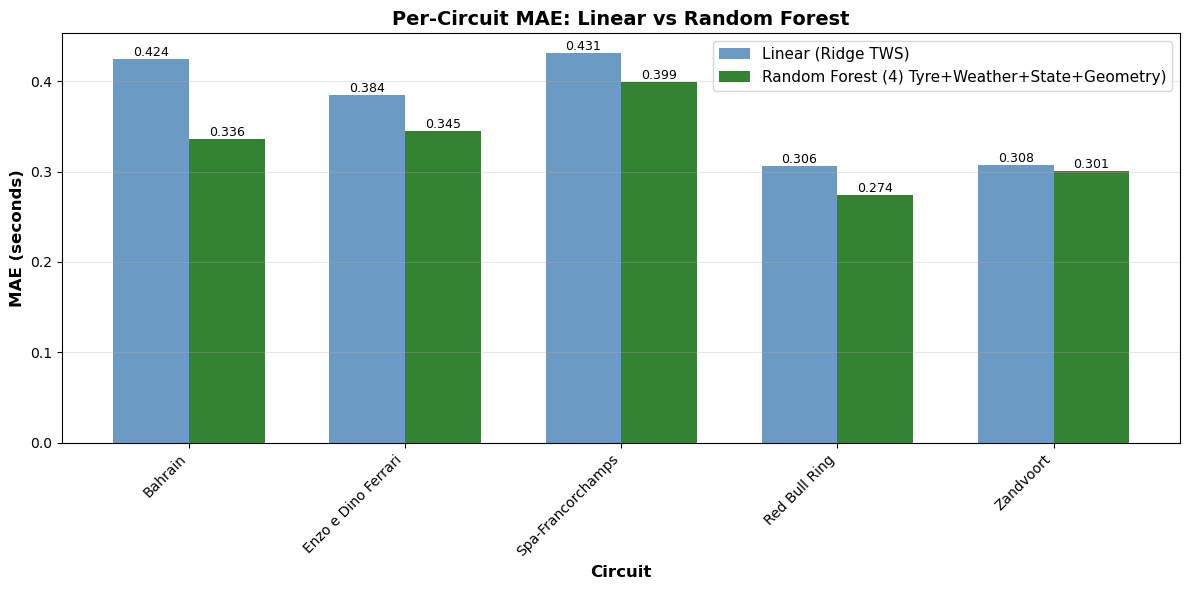

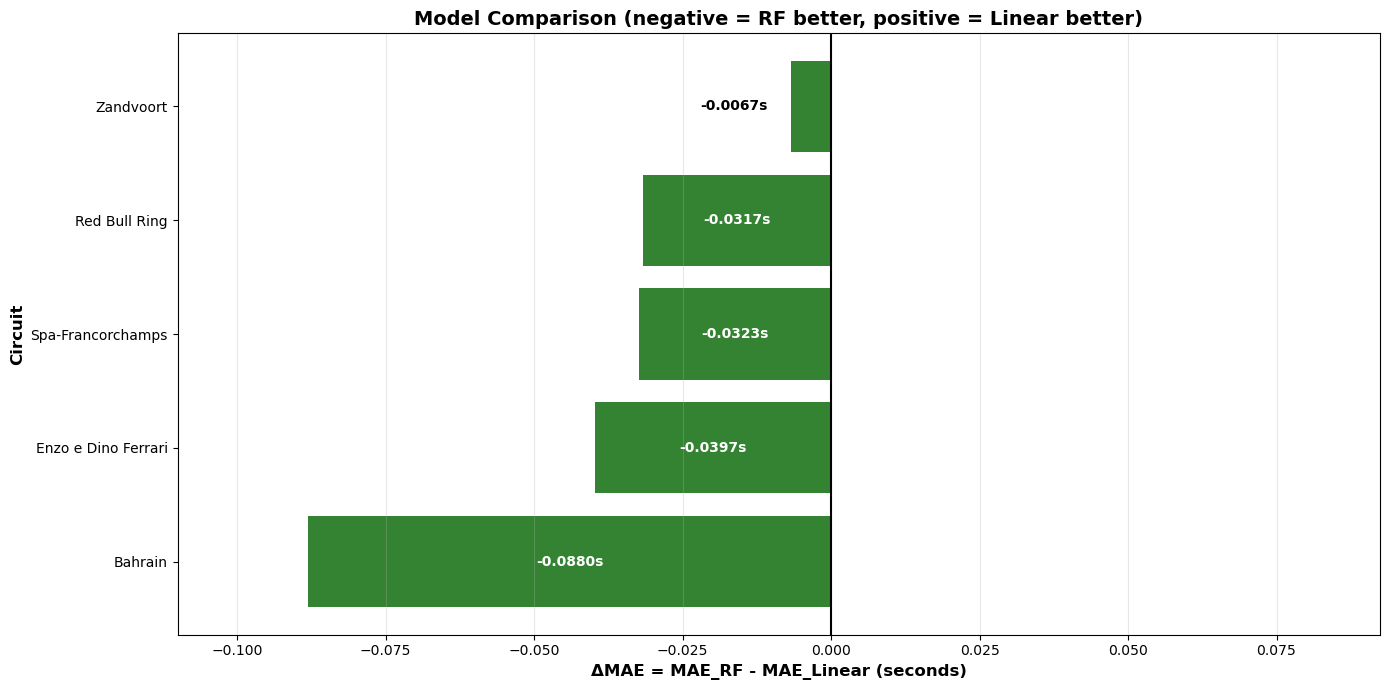

In [83]:
# CONFIGURATION

NONLINEAR_DIR = "csv_output/nonlinear"
LINEAR_DIR = "csv_output/linear"
PLOT_DIR = "figures/comparison_rf_linear"
OUTDIR = "csv_output"

os.makedirs(PLOT_DIR, exist_ok=True)


# Load and prepare data

print(f"\n Per-circuit comparison: Baseline vs Random Forest")

# Load Linear per-circuit (has MAE, median_AE, bias)
linear_path = os.path.join(LINEAR_DIR, "linear_tws_per_circuit.csv")
if not os.path.exists(linear_path):
    print(f"\nERROR: {linear_path} not found.")
    exit(1)

df_linear = pd.read_csv(linear_path)
df_linear.rename(columns={'MAE': 'MAE_Linear', 'bias': 'bias_Linear'}, inplace=True)
df_linear = df_linear[['Circuit', 'n', 'MAE_Linear', 'bias_Linear']]

# Load RF per-circuit MAE (RF with Tyre+Weather+State+Geometry only)
rf_path = os.path.join(NONLINEAR_DIR, "rf_4 Tyre_Weather_State_Geometry_per_circuit_mae.csv")

if not os.path.exists(rf_path):
    print(f"\nERROR: {rf_path} not found.")
    exit(1)

df_rf = pd.read_csv(rf_path)
df_rf.rename(columns={'MAE': 'MAE_RF'}, inplace=True)
df_rf = df_rf[['Circuit', 'MAE_RF']]

rf_feature_set = "4) Tyre+Weather+State+Geometry"

# Load RF per-circuit bias
rf_bias_path = os.path.join(NONLINEAR_DIR, "rf_4_Tyre_Weather_State_Geometry_per_circuit_bias.csv")
if not os.path.exists(rf_bias_path):
    print(f"\nERROR: {rf_bias_path} not found.")
    exit(1)

df_rf_bias = pd.read_csv(rf_bias_path)
df_rf_bias.rename(columns={'bias_RF': 'bias_RF'}, inplace=True)
df_rf_bias = df_rf_bias[['Circuit', 'bias_RF']]

print(" Data loaded successfully")


# Merge and compute delta 

print(f"\n Consolidating comparison table")

# Merge on Circuit name: Linear + RF MAE + RF bias
# Use INNER merge to ensure exactly 5 circuits in both models
df_comparison = pd.merge(
    df_linear[['Circuit', 'n', 'MAE_Linear', 'bias_Linear']],
    df_rf[['Circuit', 'MAE_RF']],
    on='Circuit',
    how='inner'
)

# Merge RF bias
df_comparison = pd.merge(
    df_comparison,
    df_rf_bias[['Circuit', 'bias_RF']],
    on='Circuit',
    how='inner'
)

# Sanity check: expect exactly 5 circuits
assert len(df_comparison) == 5, f"ERROR: Expected 5 circuits, got {len(df_comparison)}"

# Compute ΔMAE (positive = RF worse, negative = RF better)
# ΔMAE = MAE_RF - MAE_Linear
#   negative: RF has lower error (RF better)
#   positive: RF has higher error (Linear better)
df_comparison['ΔMAE'] = df_comparison['MAE_RF'] - df_comparison['MAE_Linear']
df_comparison['RF_better'] = df_comparison['ΔMAE'] < 0

# Sort by ΔMAE (RF improvements first, i.e., most negative first)
df_comparison = df_comparison.sort_values('ΔMAE', ascending=True).reset_index(drop=True)

print("Comparison table created")

# Save consolidated table
comparison_path = os.path.join(OUTDIR, "comparison_rf_geometry_vs_linear_baseline.csv")
df_comparison.to_csv(comparison_path, index=False)



# MAE Comparison (Grouped Bar Chart)


print(f"\nGenerating plots")

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, df_comparison['MAE_Linear'], width, 
               label='Linear (Ridge TWS)', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, df_comparison['MAE_RF'], width,
               label=f'Random Forest ({rf_feature_set})', color='darkgreen', alpha=0.8)

ax.set_xlabel('Circuit', fontsize=12, fontweight='bold')
ax.set_ylabel('MAE (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Per-Circuit MAE: Linear vs Random Forest', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_comparison['Circuit'], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plot1_path = os.path.join(PLOT_DIR, "mae_rf_geometry_vs_linear.pdf")
plt.savefig(plot1_path, dpi=150, bbox_inches='tight')
plt.show()
plt.close()


# ΔMAE Improvement Chart


fig, ax = plt.subplots(figsize=(14, 7))

# Color based on who wins
# Negative ΔMAE = RF better (green), Positive = Linear better (red)
colors = ['darkgreen' if delta < 0 else 'coral' for delta in df_comparison['ΔMAE']]

bars = ax.barh(df_comparison['Circuit'], df_comparison['ΔMAE'], color=colors, alpha=0.8)

ax.axvline(0, color='black', linestyle='-', linewidth=1.5)
ax.set_xlabel('ΔMAE = MAE_RF - MAE_Linear (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Circuit', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison (negative = RF better, positive = Linear better)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels with adaptive placement
for i, delta in enumerate(df_comparison['ΔMAE']):
    label = f'{delta:+.4f}s'
    
    # threshold for "small" bars
    if abs(delta) < 0.010:
        # place label outside bar (for very small bars)
        x_pos = delta + (0.004 if delta > 0 else -0.004)
        ha = 'left' if delta > 0 else 'right'
        color = 'black'
    else:
        # place label inside bar (for larger bars)
        x_pos = delta / 2
        ha = 'center'
        color = 'white'
    
    ax.text(
        x_pos, i, label,
        va='center',
        ha=ha,
        fontsize=10,
        fontweight='bold',
        color=color
    )

# Expand x-limits to avoid label clipping on left side
max_abs = abs(df_comparison['ΔMAE']).max()
ax.set_xlim(-max_abs * 1.25, max_abs * 1.05)

plt.tight_layout()

plt.tight_layout()
plot2_path = os.path.join(PLOT_DIR, "delta_mae_rf_geometry_vs_linear.pdf")
plt.savefig(plot2_path, dpi=150, bbox_inches='tight')
plt.show()
plt.close()


<h2><center> Error by compound </center></h2>


Error Analysis by Compound 


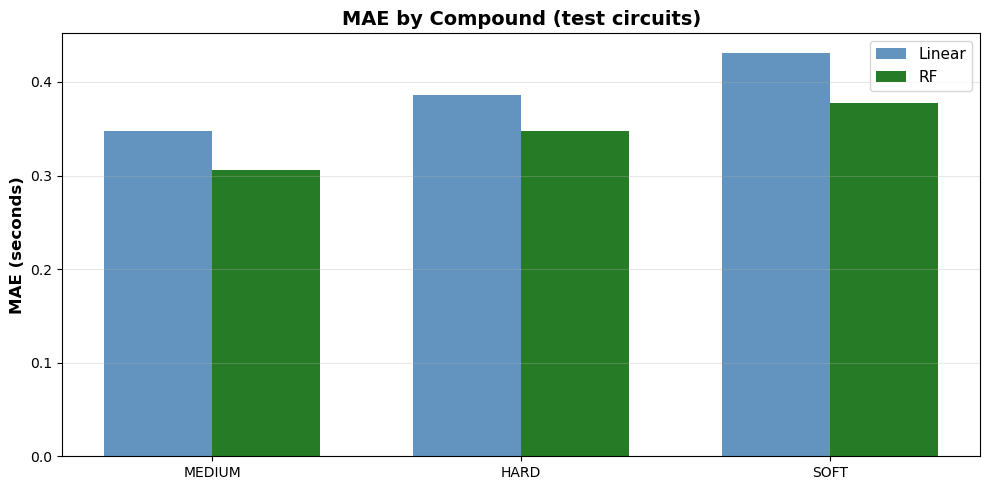

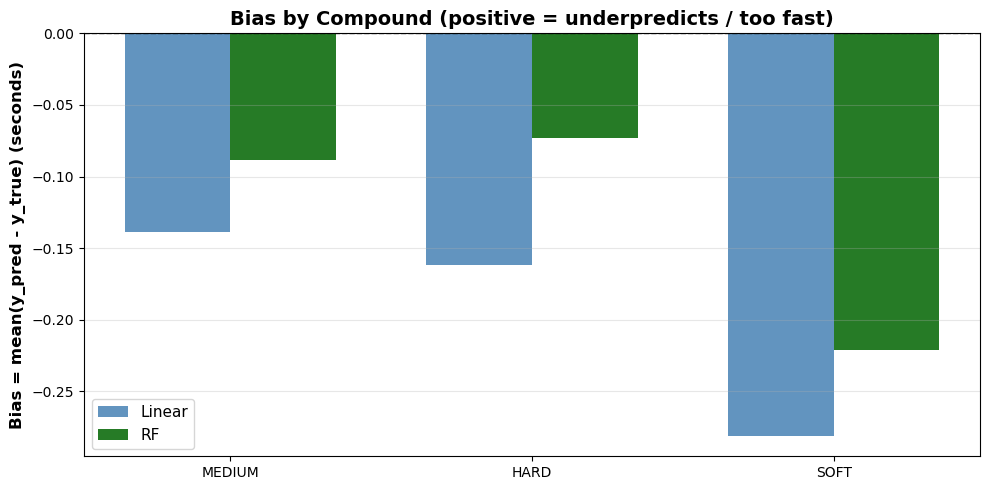

In [84]:

# Error Analysis by Compound

print(f"\nError Analysis by Compound ")


# Load row-level predictions for both models
rf_pred_path = "csv_output/nonlinear/rf_test_residuals.csv"
lin_pred_path = "csv_output/linear/linear_tws_test_predictions.csv"

if not os.path.exists(rf_pred_path):
    print(f"\nWARNING: {rf_pred_path} not found. Skipping Step 4.2.")
else:
    df_rf_pred = pd.read_csv(rf_pred_path)
    
    # Check if Linear predictions exist
    if not os.path.exists(lin_pred_path):
        print(f"\nWARNING: {lin_pred_path} not found. Skipping Step 4.2.")
    else:
        df_lin_pred = pd.read_csv(lin_pred_path)
        
        # Standardize to one signed error convention: signed_error = y_pred - y_true
        # Saved residual is y_true - y_pred, so signed_error = -residual
        df_rf_pred["signed_error"] = -df_rf_pred["residual"]
        df_rf_pred["AE"] = df_rf_pred["signed_error"].abs()
        
        df_lin_pred["signed_error"] = -df_lin_pred["residual"]
        df_lin_pred["AE"] = df_lin_pred["signed_error"].abs()
        
        # Drop missing compounds
        df_rf_pred = df_rf_pred.dropna(subset=["Compound"])
        df_lin_pred = df_lin_pred.dropna(subset=["Compound"])
        
        # Aggregate by compound
        def summarize(df, model_name):
            out = df.groupby("Compound", as_index=False).agg(
                MAE=("AE", "mean"),
                bias=("signed_error", "mean"),
                n=("AE", "size")
            )
            out["model"] = model_name
            return out
        
        rf_compound = summarize(df_rf_pred, "RF")
        lin_compound = summarize(df_lin_pred, "Linear")
        
        # Combine and sort
        compound_summary = pd.concat([rf_compound, lin_compound], ignore_index=True)
        order = compound_summary.groupby("Compound")["n"].sum().sort_values(ascending=False).index.tolist()
        compound_summary["Compound"] = pd.Categorical(compound_summary["Compound"], categories=order, ordered=True)
        compound_summary = compound_summary.sort_values(["Compound", "model"])
        
  
        # print(f"\nSummary by Compound:")

        # print(compound_summary.to_string(index=False))
        
        # Save compound summary
        compound_path = os.path.join(OUTDIR, "error_by_compound.csv")
        compound_summary.to_csv(compound_path, index=False)

        # Plot 1: MAE by Compound (grouped bars)

        compound_plot_dir = "figures/error_by_compound"
        os.makedirs(compound_plot_dir, exist_ok=True)
        
        # Pivot for grouped plotting
        pivot_mae = compound_summary.pivot(index="Compound", columns="model", values="MAE").loc[order]
        
        fig, ax = plt.subplots(figsize=(10, 5))
        x = np.arange(len(order))
        w = 0.35
        
        ax.bar(x - w/2, pivot_mae["Linear"], width=w, label="Linear", color="steelblue", alpha=0.85)
        ax.bar(x + w/2, pivot_mae["RF"], width=w, label="RF", color="darkgreen", alpha=0.85)
        
        ax.set_xticks(x)
        ax.set_xticklabels(order, rotation=0)
        ax.set_ylabel("MAE (seconds)", fontsize=12, fontweight="bold")
        ax.set_title("MAE by Compound (test circuits)", fontsize=14, fontweight="bold")
        ax.grid(axis="y", alpha=0.3)
        ax.legend(fontsize=11)
        plt.tight_layout()
        compound_plot1_path = os.path.join(compound_plot_dir, "mae_by_compound.pdf")
        plt.savefig(compound_plot1_path, dpi=150, bbox_inches="tight")
        plt.show()
        plt.close()
        
        # Plot 2: Bias by Compound (grouped bars)
        pivot_bias = compound_summary.pivot(index="Compound", columns="model", values="bias").loc[order]
        
        fig, ax = plt.subplots(figsize=(10, 5))
        
        ax.bar(x - w/2, pivot_bias["Linear"], width=w, label="Linear", color="steelblue", alpha=0.85)
        ax.bar(x + w/2, pivot_bias["RF"], width=w, label="RF", color="darkgreen", alpha=0.85)
        
        ax.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.7)
        ax.set_xticks(x)
        ax.set_xticklabels(order, rotation=0)
        ax.set_ylabel("Bias = mean(y_pred - y_true) (seconds)", fontsize=12, fontweight="bold")
        ax.set_title("Bias by Compound (positive = underpredicts / too fast)", fontsize=14, fontweight="bold")
        ax.grid(axis="y", alpha=0.3)
        ax.legend(fontsize=11)
        plt.tight_layout()
        compound_plot2_path = os.path.join(compound_plot_dir, "bias_by_compound.pdf")
        plt.savefig(compound_plot2_path, dpi=150, bbox_inches="tight")
        plt.show()
        plt.close()


<h2><center> Error by Stint </center></h2>


Error Analysis by Stint Phase


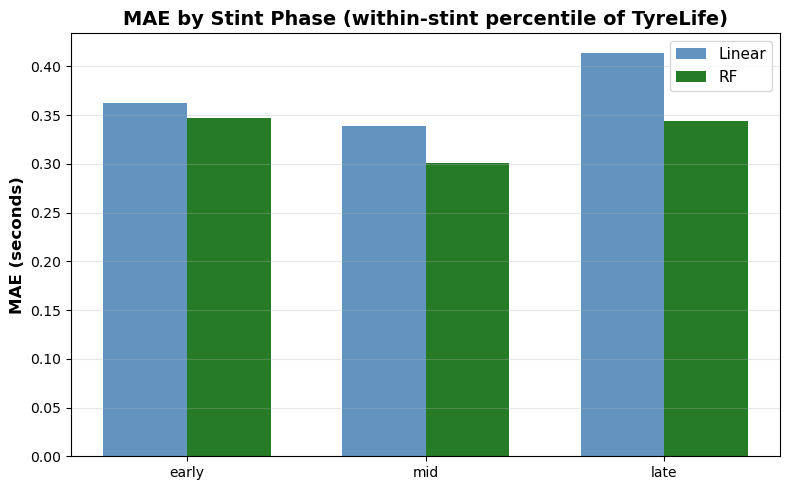

✓ Saved: figures/error_by_stint_phase/bias_by_phase.pdf


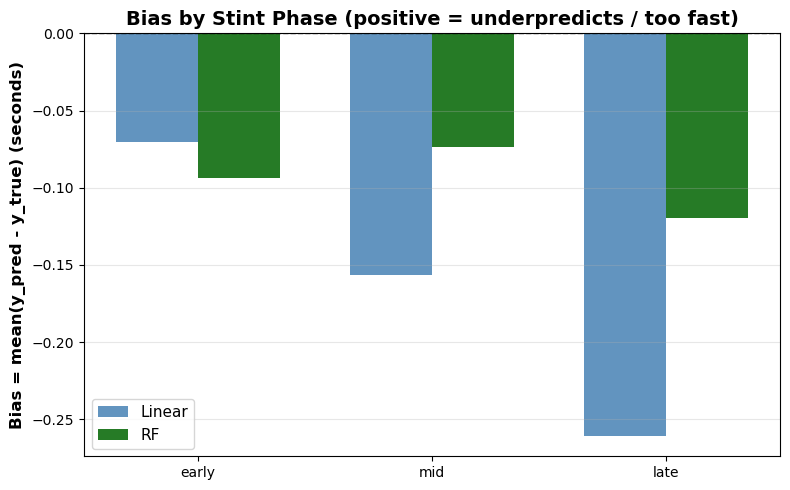

In [85]:
# =========================================================================
# ERROR ANALYSIS BY STINT PHASE
# =========================================================================

print(f"\nError Analysis by Stint Phase")


# Load prediction files (fresh copies to avoid modifying Step 4.2 data)
rf_pred_path  = "csv_output/nonlinear/rf_test_residuals.csv"
lin_pred_path = "csv_output/linear/linear_tws_test_predictions.csv"

if not os.path.exists(rf_pred_path) or not os.path.exists(lin_pred_path):
    print("✗ Prediction files not found. Run nonlinear.py and linear.py first.")
else:
    try:
        df_rf_phase = pd.read_csv(rf_pred_path)
        df_lin_phase = pd.read_csv(lin_pred_path)
        
    
        # Standardize to signed error convention: signed_error = y_pred - y_true
        for df in [df_rf_phase, df_lin_phase]:
            df["signed_error"] = -df["residual"]  # residual is y_true - y_pred
            df["AE"] = df["signed_error"].abs()
        
        # Check if Stint column exists
        if "Stint" not in df_rf_phase.columns or "Stint" not in df_lin_phase.columns:
            print(" Stint column not found in prediction files. Skipping Step 4.3.")
        else:
            # Build race_id and stint_id for grouping
            for df in [df_rf_phase, df_lin_phase]:
                df["race_id"] = (
                    df["year"].astype(str) + "__" +
                    df["round"].astype(str) + "__" +
                    df["name"].astype(str)
                )
                
                df["stint_id"] = (
                    df["race_id"].astype(str) + "__" +
                    df["RacingNumber"].astype(str) + "__" +
                    df["Stint"].astype(str)
                )
            
            # Filter out tiny stints (< 6 laps makes "early/mid/late" meaningless)
            def filter_small_stints(df, min_laps=6):
                stint_sizes = df.groupby("stint_id").size()
                valid = stint_sizes[stint_sizes >= min_laps].index
                return df[df["stint_id"].isin(valid)].copy()
            
            df_rf_phase = filter_small_stints(df_rf_phase, 6)
            df_lin_phase = filter_small_stints(df_lin_phase, 6)
    
            
            # Determine lap number column name (robust to naming variations)
            lap_col = None
            if "lap_number" in df_rf_phase.columns:
                lap_col = "lap_number"
            elif "LapNumber" in df_rf_phase.columns:
                lap_col = "LapNumber"
            
            # Make sure both models use the same sample (by unique key)
            if lap_col:
                for df in [df_rf_phase, df_lin_phase]:
                    df["sample_key"] = (
                        df["year"].astype(str) + "__" +
                        df["round"].astype(str) + "__" +
                        df["RacingNumber"].astype(str) + "__" +
                        df["Stint"].astype(str) + "__" +
                        df[lap_col].astype(str)
                    )
            else:
                # Fallback: use weaker key without lap number
                for df in [df_rf_phase, df_lin_phase]:
                    df["sample_key"] = (
                        df["year"].astype(str) + "__" +
                        df["round"].astype(str) + "__" +
                        df["name"].astype(str) + "__" +
                        df["RacingNumber"].astype(str) + "__" +
                        df["TyreLife"].astype(str) + "__" +
                        df["Compound"].astype(str) + "__" +
                        df["TrackTemp"].astype(str)
                    )
            
            # Inner merge to keep only samples in both models
            sample_rf = set(df_rf_phase["sample_key"].dropna())
            sample_lin = set(df_lin_phase["sample_key"].dropna())
            common_samples = sample_rf & sample_lin
            
            df_rf_phase = df_rf_phase[df_rf_phase["sample_key"].isin(common_samples)].copy()
            df_lin_phase = df_lin_phase[df_lin_phase["sample_key"].isin(common_samples)].copy()
            
            
            # Assign phase by within-stint percentile of TyreLife
            def add_phase_by_percentile(df):
                df = df.copy()
                df["phase_q"] = df.groupby("stint_id")["TyreLife"].rank(method="average", pct=True)
                df["phase"] = pd.cut(
                    df["phase_q"],
                    bins=[0.0, 1/3, 2/3, 1.0],
                    labels=["early", "mid", "late"],
                    include_lowest=True
                )
                return df
            
            df_rf_phase = add_phase_by_percentile(df_rf_phase)
            df_lin_phase = add_phase_by_percentile(df_lin_phase)
            

            # Aggregate by phase (simple: MAE, bias, n only)
            def summarize_by_phase(df, model_name):
                agg_dict = {
                    "MAE": ("AE", "mean"),
                    "bias": ("signed_error", "mean"),
                    "n": ("AE", "size"),
                }
                out = (df.dropna(subset=["phase"])
                       .groupby("phase", as_index=False)
                       .agg(**agg_dict))
                out["model"] = model_name
                return out
            
            phase_summary = pd.concat([
                summarize_by_phase(df_lin_phase, "Linear"),
                summarize_by_phase(df_rf_phase, "RF")
            ], ignore_index=True)
            
            # Order phases
            phase_order = ["early", "mid", "late"]
            phase_summary["phase"] = pd.Categorical(
                phase_summary["phase"],
                categories=phase_order,
                ordered=True
            )
            phase_summary = phase_summary.sort_values(["phase", "model"])
            
            # Save phase summary
            phase_path = os.path.join(OUTDIR, "error_by_stint_phase.csv")
            phase_summary.to_csv(phase_path, index=False)
            
            # Create plot directory
            phase_plot_dir = "figures/error_by_stint_phase"
            os.makedirs(phase_plot_dir, exist_ok=True)
            
            # Plot 1: MAE by Phase (grouped bars)
            
            pivot_mae = phase_summary.pivot(index="phase", columns="model", values="MAE").reindex(phase_order)
            
            fig, ax = plt.subplots(figsize=(8, 5))
            x = np.arange(len(phase_order))
            w = 0.35
            
            ax.bar(x - w/2, pivot_mae["Linear"], width=w, label="Linear", color="steelblue", alpha=0.85)
            ax.bar(x + w/2, pivot_mae["RF"], width=w, label="RF", color="darkgreen", alpha=0.85)
            
            ax.set_xticks(x)
            ax.set_xticklabels(phase_order)
            ax.set_ylabel("MAE (seconds)", fontsize=12, fontweight="bold")
            ax.set_title("MAE by Stint Phase (within-stint percentile of TyreLife)", fontsize=14, fontweight="bold")
            ax.grid(axis="y", alpha=0.3)
            ax.legend(fontsize=11)
            plt.tight_layout()
            phase_plot1_path = os.path.join(phase_plot_dir, "mae_by_phase.pdf")
            plt.savefig(phase_plot1_path, dpi=150, bbox_inches="tight")
            plt.show()
            plt.close()
            
            # Plot 2: Bias by Phase (grouped bars)
            pivot_bias = phase_summary.pivot(index="phase", columns="model", values="bias").reindex(phase_order)
            
            fig, ax = plt.subplots(figsize=(8, 5))
            
            ax.bar(x - w/2, pivot_bias["Linear"], width=w, label="Linear", color="steelblue", alpha=0.85)
            ax.bar(x + w/2, pivot_bias["RF"], width=w, label="RF", color="darkgreen", alpha=0.85)
            
            ax.axhline(0, color="black", linestyle="--", linewidth=1, alpha=0.7)
            ax.set_xticks(x)
            ax.set_xticklabels(phase_order)
            ax.set_ylabel("Bias = mean(y_pred - y_true) (seconds)", fontsize=12, fontweight="bold")
            ax.set_title("Bias by Stint Phase (positive = underpredicts / too fast)", fontsize=14, fontweight="bold")
            ax.grid(axis="y", alpha=0.3)
            ax.legend(fontsize=11)
            plt.tight_layout()
            phase_plot2_path = os.path.join(phase_plot_dir, "bias_by_phase.pdf")
            plt.savefig(phase_plot2_path, dpi=150, bbox_inches="tight")
            print(f"✓ Saved: {phase_plot2_path}")
            plt.show()
            plt.close()

    except Exception as e:
        print(f"✗ Error in Step 4.3: {e}")
        import traceback
        traceback.print_exc()


<h2><center> PDP/ICE Analysis </center></h2>

PDP/ICE ANALYSIS - Random Forest (Tyre+Weather+State+Geometry)


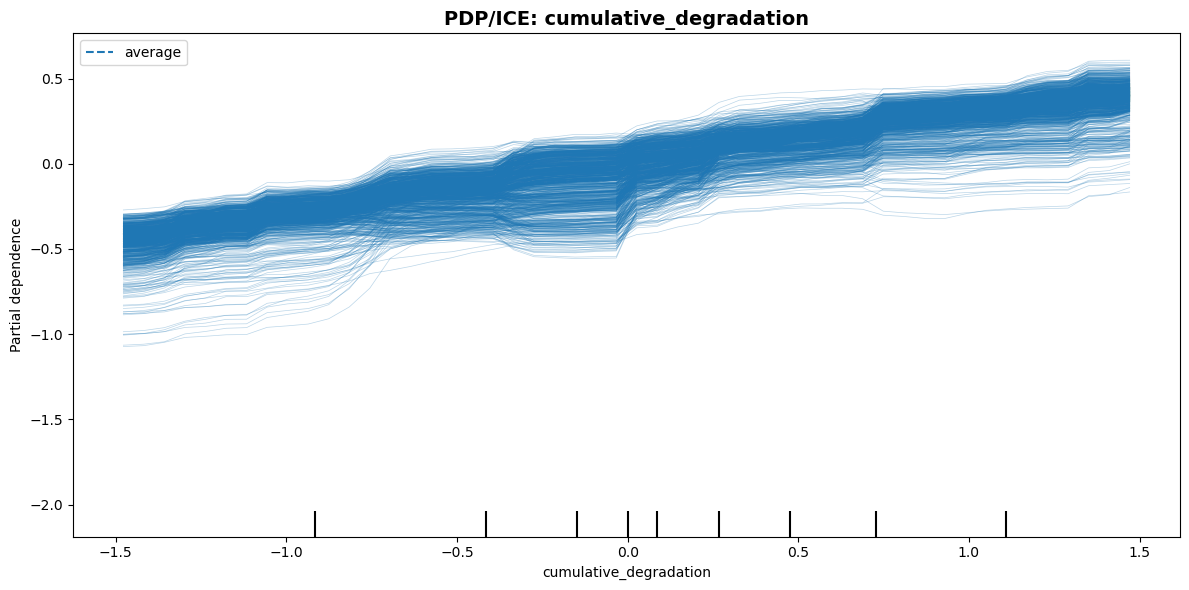

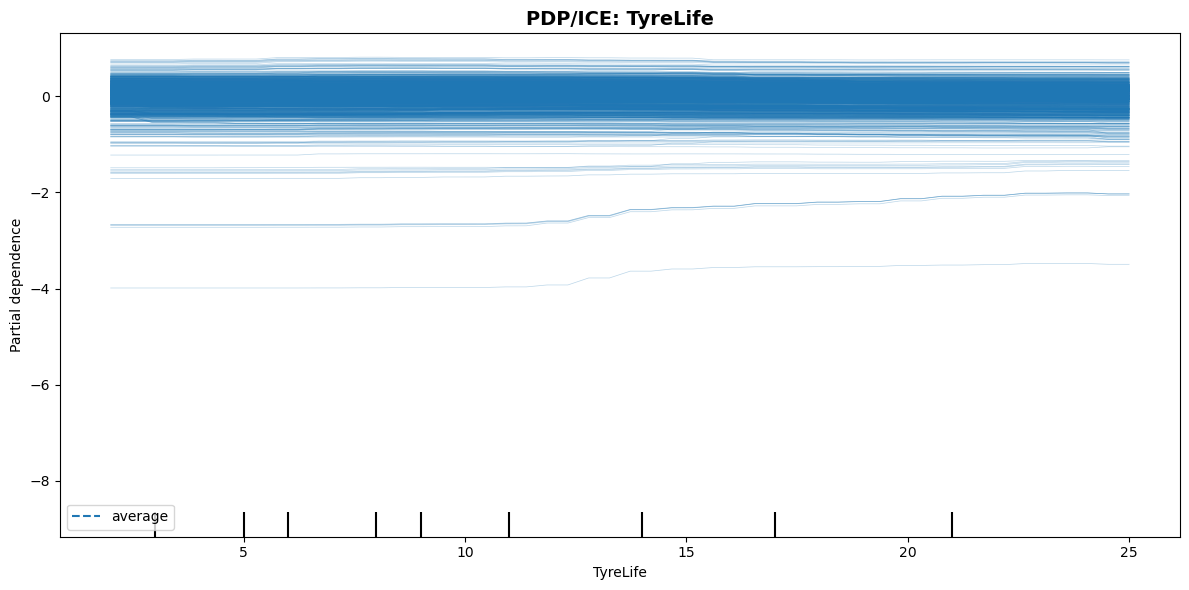

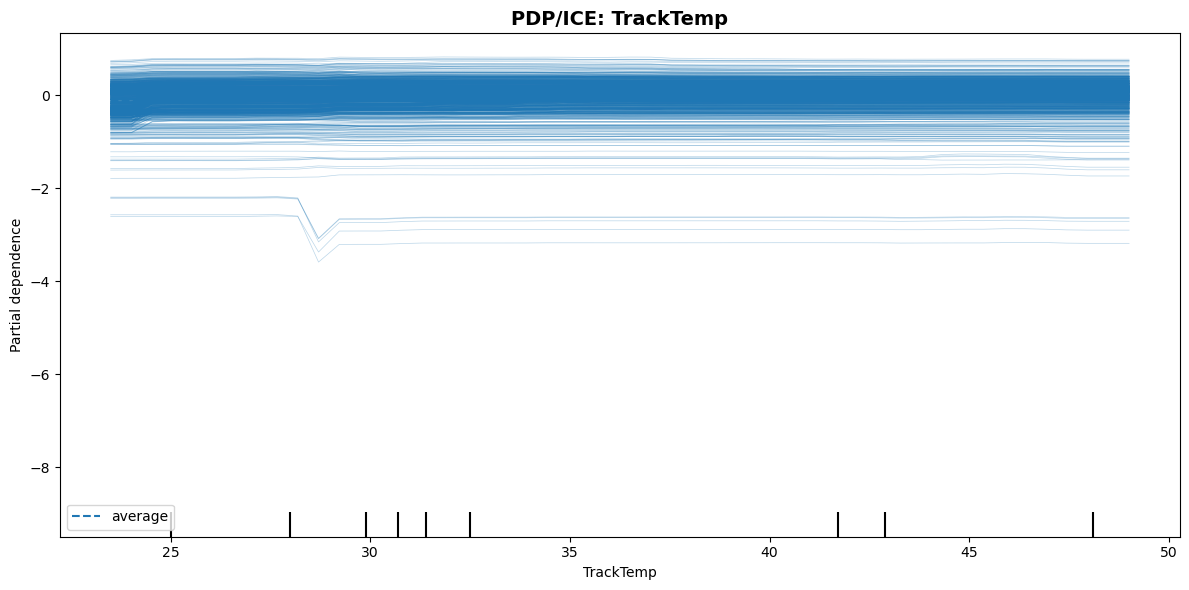

 No PDP insights generated


In [86]:

print("PDP/ICE ANALYSIS - Random Forest (Tyre+Weather+State+Geometry)")

try:
    from sklearn.inspection import PartialDependenceDisplay
    
    # Create output directory
    pdpice_outdir = os.path.join("figures", "pdp_ice")
    os.makedirs(pdpice_outdir, exist_ok=True)
    
    # Features for PDP/ICE: TyreLife and TrackTemp (actionable, high-variance)
    pdp_ice_features = ["cumulative_degradation", "TyreLife", "TrackTemp"]
    
    # Helper function: robust PDP prediction extraction (handles sklearn version differences)
    def _extract_pdp_preds(display):
        """Extract PDP predictions from sklearn PartialDependenceDisplay."""
        # Try pd_results_ (newer sklearn versions, but structure varies)
        if hasattr(display, "pd_results_") and display.pd_results_ is not None:
            try:
                r = display.pd_results_[0]
                # r can be dict-like or ndarray-like depending on sklearn version
                if isinstance(r, dict):
                    if "average" in r:
                        return np.asarray(r["average"]).ravel()
                    if "averages" in r:
                        return np.asarray(r["averages"]).ravel()
                else:
                    # Try as array
                    return np.asarray(r).ravel()
            except Exception:
                pass
        
        # Fallback: lines_ (often works for PDP in older sklearn)
        if hasattr(display, "lines_"):
            try:
                lines = display.lines_
                # Check if lines_ is non-empty (avoid ambiguous truth value)
                if lines is not None and len(lines) > 0:
                    return display.lines_[0][0].get_ydata()
            except Exception:
                pass
        
        return None
    
    pdp_insights = []
    
    for feat_name in pdp_ice_features:
        # Check feature exists in X_test
        if feat_name not in X_test.columns:
            continue
        
        # Get feature values by name
        feat_values = X_test[feat_name].to_numpy()
        feat_values_valid = feat_values[~np.isnan(feat_values)]
        
        if len(feat_values_valid) == 0:
            continue
        
        # Create PDP/ICE plot
        fig, ax = plt.subplots(figsize=(12, 6))
        
        try:
            # Try kind='both' (PDP + ICE) with subsampling
            display = PartialDependenceDisplay.from_estimator(
                pipeline,
                X_test,
                features=[feat_name],
                kind='both',
                grid_resolution=50,
                percentiles=(0.05, 0.95),
                subsample=1000,
                random_state=42,
                n_jobs=-1,
                ax=ax
            )
        except (TypeError, ValueError):
            # Fallback: kind='average' only (if subsample not supported)
            display = PartialDependenceDisplay.from_estimator(
                pipeline,
                X_test,
                features=[feat_name],
                kind='average',
                grid_resolution=50,
                percentiles=(0.05, 0.95),
                n_jobs=-1,
                ax=ax
            )
        
        # Accurate labels
        ax.set_title(f'PDP/ICE: {feat_name}', fontsize=14, fontweight='bold')
        ax.set_ylabel('Predicted LapTime Delta (seconds)', fontsize=12)
        ax.set_xlabel(f'{feat_name}', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        fig_path = os.path.join(pdpice_outdir, f"pdp_ice_{feat_name}.pdf")
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
        
        # Extract insights robustly
        insight_dict = {
            "feature": feat_name,
            "min_value": feat_values_valid.min(),
            "max_value": feat_values_valid.max(),
            "mean_value": feat_values_valid.mean(),
            "std_value": feat_values_valid.std(),
            "effect_range_s": None,
            "net_change_direction": None
        }
        
        # Extract PDP predictions using robust helper
        pdp_preds = _extract_pdp_preds(display)
        if pdp_preds is not None and len(pdp_preds) > 1:
            effect_range = float(np.max(pdp_preds) - np.min(pdp_preds))
            
            # Check for non-monotonicity to avoid mislabeling U-shaped curves
            if len(pdp_preds) > 2:
                d = np.diff(pdp_preds)
                # Ignore tiny wiggles (< 1e-6)
                s = np.sign(d[np.abs(d) > 1e-6])
                # If sign of derivative changes, curve is non-monotonic
                if len(s) > 0 and np.any(s[1:] != s[:-1]):
                    net_direction = "non-monotonic"
                else:
                    net_direction = "increases" if pdp_preds[-1] > pdp_preds[0] else "decreases"
            else:
                net_direction = "increases" if pdp_preds[-1] > pdp_preds[0] else "decreases"
            
            insight_dict["effect_range_s"] = effect_range
            insight_dict["net_change_direction"] = net_direction
        
        pdp_insights.append(insight_dict)
    
        
    else:
        print(" No PDP insights generated")

except Exception as e:
    print(f"✗ Error in Step 7.3: {e}")
    import traceback
    traceback.print_exc()


<h1><center> RF features Importance  </center></h1>

<h3><center> We will analyze the global model and then by compound to see if there are differences or not </center></h3>


PERMUTATION IMPORTANCE - Random Forest (Test Set, Global)
Using RF model: Tyre+Weather+State+Geometry
  Features: 32 | Importances: 32

✓ Saved: rf_permutation_importance_global.csv


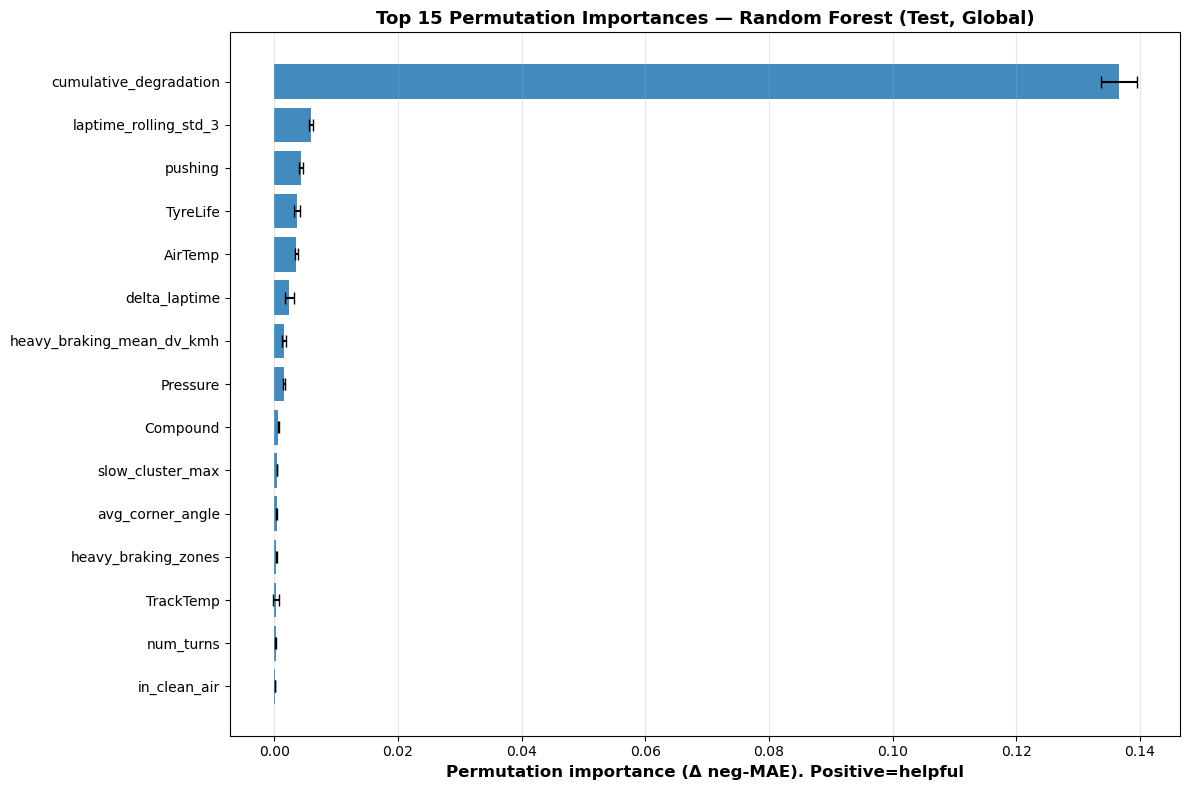

In [87]:

print(f"\nPERMUTATION IMPORTANCE - Random Forest (Test Set, Global)")
print("Using RF model: Tyre+Weather+State+Geometry")


import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# --- 0) Verify we're using the correct RF pipeline ---
# The RF was trained on: best_num_feats + CAT
# X_test is already subset to these features (line 686)
assert X_test.shape[1] == len(best_num_feats + CAT), \
    "X_test shape doesn't match best_num_feats + CAT. Check feature alignment."

# Compute permutation importance on test set
perm = permutation_importance(
    estimator=pipeline,
    X=X_test,
    y=y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="neg_mean_absolute_error"
)

# Get correct feature names (from pipeline INPUT, not transformed)
if isinstance(X_test, pd.DataFrame):
    feature_names = np.array(X_test.columns)
else:
    feature_names = np.array(best_num_feats + CAT)

# Sanity check
assert len(feature_names) == len(perm.importances_mean), \
    f"CRITICAL: Feature names ({len(feature_names)}) != importances ({len(perm.importances_mean)}). " \
    f"X_test has {X_test.shape[1]} columns."

print(f"  Features: {len(feature_names)} | Importances: {len(perm.importances_mean)}")

# --- 3) Build dataframe ---
perm_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

# Save full table
perm_imp_path = os.path.join(OUTDIR, "rf_perm_importance", "rf_permutation_importance_global.csv")
os.makedirs(os.path.dirname(perm_imp_path), exist_ok=True)
perm_imp_df.to_csv(perm_imp_path, index=False)
print(f"\n✓ Saved: {os.path.basename(perm_imp_path)}")

# --- Top 15 plot ---
top15 = perm_imp_df.head(15).copy()

fig, ax = plt.subplots(figsize=(12, 8))
top15_sorted = top15.sort_values("importance_mean")
ax.barh(
    range(len(top15_sorted)),
    top15_sorted["importance_mean"],
    xerr=top15_sorted["importance_std"],
    alpha=0.85,
    capsize=4
)
ax.set_yticks(range(len(top15_sorted)))
ax.set_yticklabels(top15_sorted["feature"], fontsize=10)
ax.set_xlabel("Permutation importance (Δ neg-MAE). Positive=helpful", fontsize=12, fontweight='bold')
ax.set_title("Top 15 Permutation Importances — Random Forest (Test, Global)", 
             fontsize=13, fontweight='bold')
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()

fig_path = os.path.join(OUTDIR, "rf_perm_importance", "rf_permutation_importance_top15_global.pdf")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()
plt.close()




Permutation Importance - Within Each Compound
Compound analysis (6976 rows, 32 features):

  HARD: 2922 samples → 2922 valid → top 10 features → 

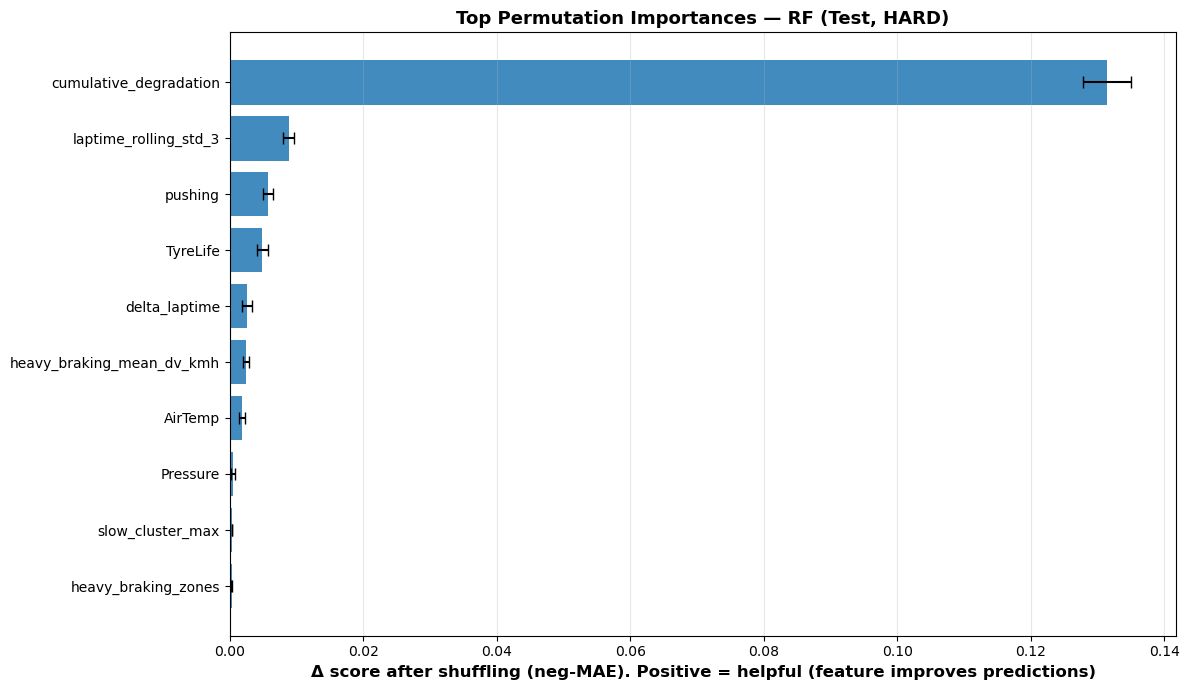


  MEDIUM: 3057 samples → 3057 valid → top 10 features → 

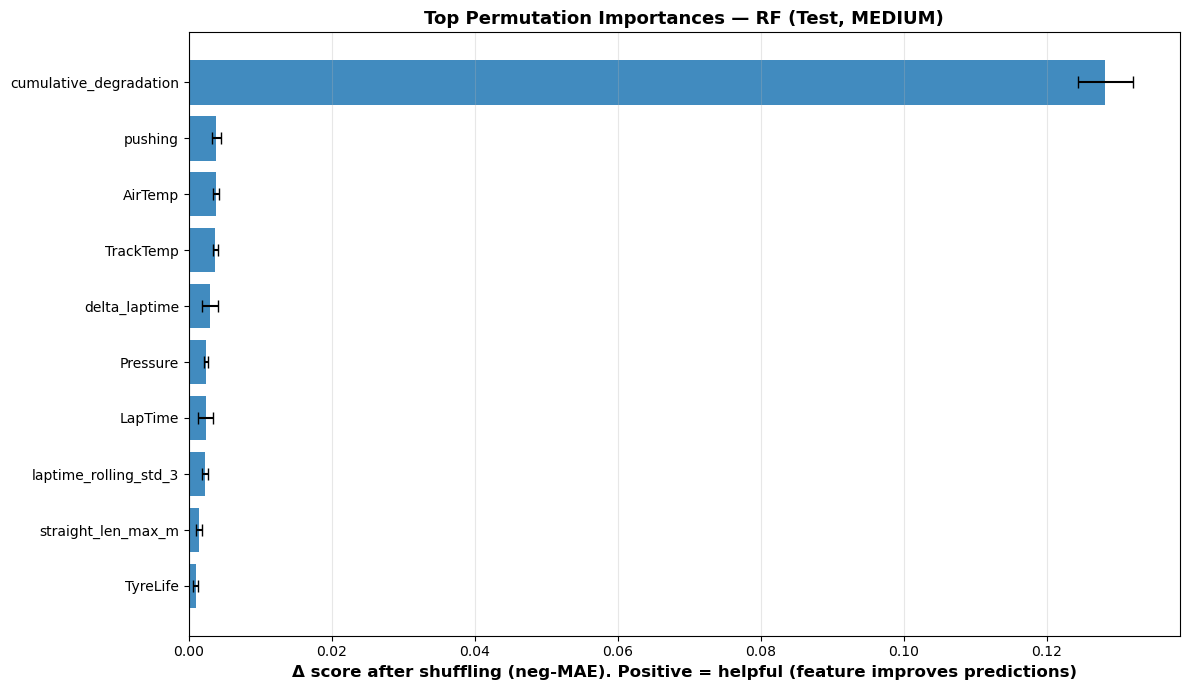


  SOFT: 997 samples → 997 valid → top 10 features → 

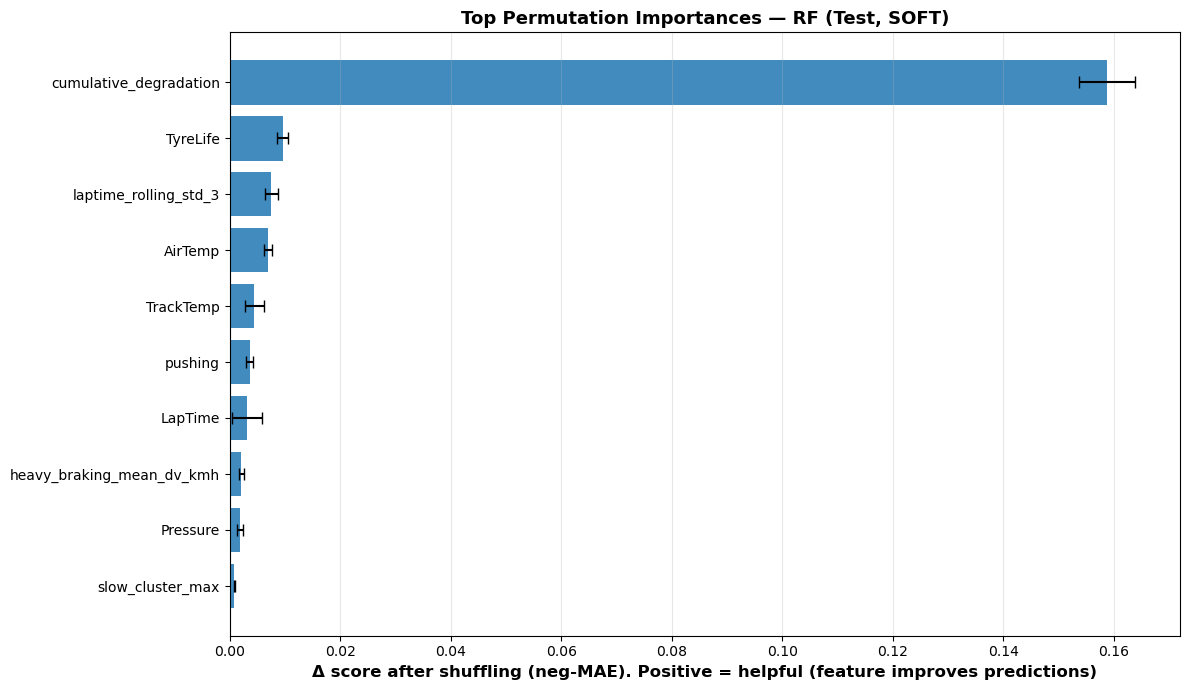

In [88]:
# PERMUTATION IMPORTANCE - Within Each Compound (Separate Analysis)

print(f"\nPermutation Importance - Within Each Compound")

# Preserve feature_names from global section (in case of Jupyter cell execution)
if "feature_names" not in locals() or feature_names is None:
    print("[WARN] feature_names not in scope, re-extracting...")
    if isinstance(X_test, pd.DataFrame):
        feature_names = np.array(X_test.columns)
    else:
        feature_names = np.array(best_num_feats + CAT)

# df_test_meta must be aligned with X_test/y_test row order
df_test_meta = df_test_sorted.reset_index(drop=True)

# Sanity check: df_test_meta and X_test must have same number of rows
assert len(df_test_meta) == X_test.shape[0], \
    f"Row alignment error: df_test_meta has {len(df_test_meta)} rows but X_test has {X_test.shape[0]} rows."

print(f"Compound analysis ({len(df_test_meta)} rows, {len(feature_names)} features):")

for compound in sorted(df_test_meta["Compound"].dropna().unique()):
    mask = (df_test_meta["Compound"] == compound).to_numpy()
    n = int(mask.sum())

    print(f"\n  {compound}: {n} samples", end=" → ")
    
    # Keep X_subset as DataFrame (preprocessor needs column names)
    X_subset = X_test[mask]
    y_subset = np.asarray(y_test[mask])
    
    # Remove NaN values from y (and corresponding X rows)
    valid_mask = ~np.isnan(y_subset)
    X_subset = X_subset[valid_mask]
    y_subset = y_subset[valid_mask]
    
    n_valid = len(y_subset)
    
    # Single stability threshold (after removing NaN)
    if n_valid < 150:
        print(f"Skipped ({n_valid} valid)")
        continue
    
    print(f"{n_valid} valid", end=" → ")
    
    perm_c = permutation_importance(
        pipeline,
        X_subset,
        y_subset,
        n_repeats=10,
        random_state=42,
        n_jobs=-1,
        scoring="neg_mean_absolute_error"
    )

    # Sanity check: importances length must match feature names
    assert len(perm_c.importances_mean) == len(feature_names), \
        f"Permutation importance length mismatch for {compound}: " \
        f"{len(perm_c.importances_mean)} importances vs {len(feature_names)} features"

    df_c = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": perm_c.importances_mean,
        "importance_std": perm_c.importances_std
    }).sort_values("importance_mean", ascending=False)

    # Save full table (all features)
    out_csv = os.path.join(OUTDIR, "rf_perm_importance", f"rf_permutation_importance_{compound}.csv")
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    df_c.to_csv(out_csv, index=False)
    
    # Save positive-only table
    df_c_pos_all = df_c[df_c["importance_mean"] > 0]
    if len(df_c_pos_all) > 0:
        out_csv_pos = os.path.join(OUTDIR, "rf_perm_importance", f"rf_permutation_importance_{compound}_positive.csv")
        df_c_pos_all.to_csv(out_csv_pos, index=False)

    # Top 10 (positive importances only)
    df_c_pos = df_c[df_c["importance_mean"] > 0]
    top10 = df_c_pos.head(10).copy()
    
    if len(top10) == 0:
        print("no positive importance")
        continue
    
    print(f"top {len(top10)} features", end=" → ")

    fig, ax = plt.subplots(figsize=(12, 7))
    top10_sorted = top10.sort_values("importance_mean")
    ax.barh(
        range(len(top10_sorted)),
        top10_sorted["importance_mean"],
        xerr=top10_sorted["importance_std"],
        alpha=0.85,
        capsize=4
    )
    ax.set_yticks(range(len(top10_sorted)))
    ax.set_yticklabels(top10_sorted["feature"], fontsize=10)
    ax.set_xlabel("Δ score after shuffling (neg-MAE). Positive = helpful (feature improves predictions)", 
                  fontsize=12, fontweight='bold')
    ax.set_title(f"Top Permutation Importances — RF (Test, {compound})", fontsize=13, fontweight='bold')
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    out_fig = os.path.join(OUTDIR, "rf_perm_importance", f"rf_permutation_importance_top10_{compound}.pdf")
    plt.savefig(out_fig, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

